In [1]:
!pip install resampy
!pip install --upgrade librosa
!pip install  tqdm
!pip install scikit-optimize
!pip install keras-tuner

In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import librosa.display
import tensorflow as tf
from tqdm import tqdm

2025-04-19 15:13:25.054171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-19 15:13:25.054326: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-19 15:13:25.148857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-19 15:13:25.335230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-19 15:13:27.158328: W tensorflow/compiler/tf2

In [3]:
# Define dataset path
audio_dataset_path = "/notebooks/UrbanSound8K/audio"
dataset_path = "/notebooks/UrbanSound8K"
metadata_path = os.path.join(dataset_path, "metadata", "UrbanSound8K.csv")

In [4]:
metadata = pd.read_csv(metadata_path)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [5]:
import numpy as np
import librosa
import scipy.signal as signal
from scipy.signal import butter, lfilter

def fix_short_audio(audio, sr, min_duration=2.0):
    """
    Ensures the audio is at least `min_duration` seconds long by repeating (tiling) it.
    """
    desired_length = int(sr * min_duration)
    if len(audio) < desired_length:
        repeat_times = (desired_length // len(audio)) + 1
        audio = np.tile(audio, repeat_times)
        audio = audio[:desired_length]
    return audio

In [6]:
def extract_features_from_audio(audio, sr, T=62, n_mels=128, n_fft=1024, hop_length=256):
    """
    Extracts log-Mel spectrogram features from an audio signal:
      - Computes a Mel spectrogram using n_mels filters.
      - Converts the power spectrogram to dB scale (log-Mel spectrogram).
      - Pads or truncates along the time axis to T frames.
      - Adds a channel dimension to yield shape (n_mels, T, 1).
    """
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels,
                                       n_fft=n_fft, hop_length=hop_length)
    log_S = librosa.power_to_db(S, ref=np.max)
    T_actual = log_S.shape[1]
    if T_actual < T:
        pad_width = T - T_actual
        log_S = np.pad(log_S, ((0, 0), (0, pad_width)), mode='constant')
    else:
        log_S = log_S[:, :T]
    # Expand dims to get shape (n_mels, T, 1)
    log_S = np.expand_dims(log_S, axis=-1)
    return log_S.astype(np.float32)

In [7]:
def stutter_effect(audio, sr, max_stutters=3):
    """
    Randomly repeats short segments of the audio to simulate a stutter effect (e.g., repeated horn blasts).
    """
    stuttered = audio.copy()
    num_stutters = np.random.randint(1, max_stutters+1)
    for _ in range(num_stutters):
        seg_len = np.random.randint(int(0.05*sr), int(0.15*sr))  # 50-150 ms
        start = np.random.randint(0, len(stuttered)-seg_len)
        segment = stuttered[start:start+seg_len]
        insert_at = np.random.randint(0, len(stuttered))
        stuttered = np.concatenate((stuttered[:insert_at], segment, stuttered[insert_at:]))
    return stuttered[:len(audio)]


In [8]:
def highpass_filter(data, sr, cutoff=1000, order=5):
    """
    Applies a Butterworth high-pass filter to emphasize high-frequency transients.
    """
    nyq = 0.5 * sr
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return lfilter(b, a, data)

In [9]:
def augment_audio(audio, sr, label=None):
    """
    Applies label-specific augmentations to the audio and returns a list of augmented audios.
    
    The audio is first fixed to be at least 2 seconds long.
    
    Logic for UrbanSound8K:
      - For "car_horn": slight time stretch, minimal pitch shift, stutter effect, moderate reverb, slight noise, peak replication.
      - For "jackhammer" or "drilling": narrow time stretch, wider pitch shift, time shift, gain adjustment, amplitude modulation.
      - For "siren" or "children_playing": controlled time stretch/pitch shift, time shift, gain adjustment, light echo.
      - For "gun_shot": high-pass filtering, transient enhancement (boost onsets), peak replication, slight noise.
      - Otherwise (e.g. "air_conditioner", "dog_bark", "engine_idling", "street_music"): default augmentations (time stretch, pitch shift, time shift, gain) are applied.
    """
    # To ensure the audio is at least 2 seconds long.
    audio = fix_short_audio(audio, sr, min_duration=2.0)
    augmented_audios = []
    
    if label is not None:
        label_lower = label.lower()
        if label_lower == "car_horn":
            # 1. Slight time stretch
            rate = np.random.uniform(0.95, 1.05)
            stretched = librosa.effects.time_stretch(audio, rate=rate)[:len(audio)]
            augmented_audios.append(stretched)
            # 2. Minimal pitch shift
            n_steps = np.random.uniform(-0.5, 0.5)
            pitch_aug = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)[:len(audio)]
            augmented_audios.append(pitch_aug)
            # 3. Stutter effect
            stuttered = stutter_effect(audio, sr, max_stutters=3)
            augmented_audios.append(stuttered)
            # 4. Moderate reverb
            ir_length = int(0.02 * sr)
            impulse_response = np.exp(-np.linspace(0, 2, ir_length))
            impulse_response /= np.sum(impulse_response)
            reverb_audio = signal.convolve(audio, impulse_response, mode='full')[:len(audio)]
            augmented_audios.append(reverb_audio)
            # 5. Slight noise
            noise = np.random.normal(0, 0.003, size=audio.shape)
            noisy_audio = audio + noise
            augmented_audios.append(noisy_audio)
            # 6. Peak replication
            peaks = librosa.util.peak_pick(audio, pre_max=3, post_max=3, pre_avg=3, post_avg=3, delta=0.01, wait=0)
            replicated = np.zeros_like(audio)
            for peak in peaks:
                rep_len = int(0.1 * sr)
                if peak + rep_len < len(audio):
                    rand_index = np.random.randint(0, len(audio) - rep_len)
                    replicated[rand_index:rand_index + rep_len] += audio[peak:peak + rep_len]
            replicated = replicated / (np.max(np.abs(replicated)) + 1e-6)
            augmented_audios.append(replicated)
        
        elif label_lower in ["jackhammer", "drilling"]:
            # 1. Narrow time stretch
            rate = np.random.uniform(0.95, 1.05)
            stretched = librosa.effects.time_stretch(audio, rate=rate)[:len(audio)]
            augmented_audios.append(stretched)
            # 2. Wider pitch shift
            n_steps = np.random.uniform(-3, 3)
            pitch_aug = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)[:len(audio)]
            augmented_audios.append(pitch_aug)
            # 3. Time shift (roll)
            shift_range = int(0.2 * len(audio))
            shift = np.random.randint(-shift_range, shift_range)
            time_shifted = np.roll(audio, shift)
            augmented_audios.append(time_shifted)
            # 4. Gain adjustment
            gain = np.random.uniform(0.7, 1.3)
            gain_aug = audio * gain
            augmented_audios.append(gain_aug)
            # 5. Amplitude modulation
            t = np.linspace(0, 1, len(audio))
            mod_freq = np.random.uniform(2, 8)
            mod_signal = 1.0 + 0.2 * np.sin(2 * np.pi * mod_freq * t)
            amp_mod_audio = audio * mod_signal
            augmented_audios.append(amp_mod_audio)
        
        elif label_lower in ["siren", "children_playing"]:
            # Use similar logic for both "siren" and "children_playing"
            if label_lower == "siren":
                rate = np.random.uniform(0.9, 1.1)
                n_steps = np.random.uniform(-1, 1)
            else:
                rate = np.random.uniform(0.85, 1.15)
                n_steps = np.random.uniform(-2, 2)
            stretched = librosa.effects.time_stretch(audio, rate=rate)[:len(audio)]
            augmented_audios.append(stretched)
            pitch_aug = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)[:len(audio)]
            augmented_audios.append(pitch_aug)
            shift_range = int(0.2 * len(audio))
            shift = np.random.randint(-shift_range, shift_range)
            time_shifted = np.roll(audio, shift)
            augmented_audios.append(time_shifted)
            # Gain adjustment
            if label_lower == "siren":
                gain = np.random.uniform(0.8, 1.2)
            else:
                gain = np.random.uniform(0.7, 1.3)
            gain_aug = audio * gain
            augmented_audios.append(gain_aug)
            # Light echo
            ir_length = int(0.01 * sr)
            impulse_response = np.exp(-np.linspace(0, 2, ir_length))
            impulse_response /= np.sum(impulse_response)
            env_audio = signal.convolve(audio, impulse_response, mode='full')[:len(audio)]
            augmented_audios.append(env_audio)
        
        elif label_lower == "gun_shot":
            # 1. High-pass filter
            filtered = highpass_filter(audio, sr, cutoff=1000, order=5)
            augmented_audios.append(filtered)
            # 2. Enhance transients (boost onsets)
            onsets = librosa.onset.onset_detect(y=audio, sr=sr, backtrack=True)
            envelope = np.ones_like(audio)
            for onset in onsets:
                start = max(0, onset - int(0.01 * sr))
                end = min(len(audio), onset + int(0.05 * sr))
                envelope[start:end] *= 1.5
            enhanced = audio * envelope
            augmented_audios.append(enhanced)
            # 3. Replicate gunshot events
            peaks = librosa.util.peak_pick(filtered, pre_max=3, post_max=3, pre_avg=3, post_avg=3, delta=0.01, wait=0)
            replicated = np.zeros_like(audio)
            for peak in peaks:
                rep_len = int(0.1 * sr)
                if peak + rep_len < len(audio):
                    rand_index = np.random.randint(0, len(audio) - rep_len)
                    replicated[rand_index:rand_index + rep_len] += audio[peak:peak + rep_len]
            replicated = replicated / (np.max(np.abs(replicated)) + 1e-6)
            augmented_audios.append(replicated)
            # 4. Slight noise
            noise = np.random.normal(0, 0.003, size=audio.shape)
            noisy = audio + noise
            augmented_audios.append(noisy)
        
        else:
            # Default augmentations for remaining classes:
            # (e.g., "air_conditioner", "dog_bark", "engine_idling", "street_music")
            # 1. Time stretch
            rate = np.random.uniform(0.95, 1.05)
            stretched = librosa.effects.time_stretch(audio, rate=rate)[:len(audio)]
            augmented_audios.append(stretched)
            # 2. Pitch shift
            n_steps = np.random.uniform(-1, 1)
            pitch_aug = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)[:len(audio)]
            augmented_audios.append(pitch_aug)
            # 3. Time shift
            shift_range = int(0.2 * len(audio))
            shift = np.random.randint(-shift_range, shift_range)
            time_shifted = np.roll(audio, shift)
            augmented_audios.append(time_shifted)
            # 4. Gain adjustment
            gain = np.random.uniform(0.8, 1.2)
            gain_aug = audio * gain
            augmented_audios.append(gain_aug)
    
    return augmented_audios


In [10]:
def features_extractor(file, augment=True, T=62, n_mels=128, n_fft=1024, hop_length=256, label=None):
    """
    Loads an audio file, ensures minimum length, and extracts features using log-Mel spectrograms.
    Returns a list of feature matrices, each with shape (n_mels, T, 1):
      - If augment=False: returns [base_feature]
      - If augment=True: returns [base_feature] + augmented versions.
    """
    audio, sr = librosa.load(file, res_type='kaiser_fast', sr=16000)
    audio = fix_short_audio(audio, sr, min_duration=2.0)
    base_feat = extract_features_from_audio(audio, sr, T=T, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    if augment:
        feats = [base_feat]
        aug_audios = augment_audio(audio, sr, label=label)
        for aug in aug_audios:
            feats.append(extract_features_from_audio(aug, sr, T=T, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length))
        return feats
    else:
        return [base_feat]

In [11]:
import random

def single_augment_feature(file, sr=16000, T=62, n_mels=128, n_fft=1024, hop_length=256, label=None):
    """
    For oversampling: randomly chooses one augmentation method and extracts features using log-Mel spectrograms.
    Ensures the audio is at least 2 seconds long.
    Returns a feature matrix of shape (n_mels, T, 1).
    """
    audio, sr = librosa.load(file, res_type='kaiser_fast', sr=sr)
    audio = fix_short_audio(audio, sr, min_duration=2.0)
    
    # Only use the specialized augmentations for valid UrbanSound8K labels
    valid_labels = ["car_horn", "jackhammer", "drilling", "siren", "children_playing", "gun_shot"]
    if label is not None and label.lower() in valid_labels:
        aug_options = augment_audio(audio, sr, label=label)
        augmented_audio = random.choice(aug_options)
    else:
        choice = np.random.choice(["noise", "stretch", "pitch"])
        if choice == "noise":
            noise_amp = 0.005 * np.random.uniform() * np.amax(audio)
            augmented_audio = audio + noise_amp * np.random.normal(size=audio.shape[0])
        elif choice == "stretch":
            rate = np.random.uniform(0.9, 1.1)
            aug_audio = librosa.effects.time_stretch(audio, rate=rate)
            augmented_audio = aug_audio[:len(audio)]
        else:
            n_steps = np.random.uniform(-2, 2)
            augmented_audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
            augmented_audio = augmented_audio[:len(audio)]
    
    return extract_features_from_audio(augmented_audio, sr, T=T, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)


In [ ]:
# Set parameters for base dataset
max_samples = 1000  # Desired number of non-augmented samples per class
T = 62  
n_mels = 128  
n_fft = 1024
hop_length = 256


# Build base dataset: collect at most 1000 original samples per class
class_counts = {cls: 0 for cls in metadata["class"].unique()}
base_features = []
base_labels = []
base_file_paths = []

for _, row in tqdm(metadata.iterrows(), total=len(metadata), desc="Collecting base samples"):
    file_path = os.path.join(audio_dataset_path, f'fold{row["fold"]}', row["slice_file_name"])
    label = row["class"]
    if class_counts[label] < max_samples:
        # features_extractor returns a list; we take the first (non-augmented) feature.
        feat = features_extractor(
            file_path, 
            augment=False, 
            T=T, 
            n_mels=n_mels, 
            n_fft=n_fft, 
            hop_length=hop_length,
            label=label
        )[0]
        base_features.append(feat)
        base_labels.append(label)
        base_file_paths.append(file_path)
        class_counts[label] += 1

# For classes with fewer than 1000 samples, oversample using single_augment_feature.
for label in tqdm(class_counts.keys(), desc="Oversampling to 1000 per class"):
    while class_counts[label] < max_samples:
        # Choose one file from those already in the base set for this label
        indices = [i for i, lab in enumerate(base_labels) if lab == label]
        available_files = [base_file_paths[i] for i in indices]
        random_file = np.random.choice(available_files)
        feat = single_augment_feature(
            random_file, 
            T=T, 
            n_mels=n_mels, 
            n_fft=n_fft, 
            hop_length=hop_length,
            label=label
        )
        base_features.append(feat)
        base_labels.append(label)
        base_file_paths.append(random_file)
        class_counts[label] += 1

base_features = np.array(base_features)
base_labels = np.array(base_labels)
print("Balanced base dataset features shape:", base_features.shape)
print("Balanced base dataset labels shape:", base_labels.shape)


In [ ]:
from itertools import cycle
from tqdm import tqdm

target_samples = 6000  # Final total samples per class (base + augmented)

# Create a mapping from each class to its base file paths
class_to_files = {}
for file_path, label in zip(base_file_paths, base_labels):
    class_to_files.setdefault(label, []).append(file_path)

# Initialize the final dataset with the base dataset
final_features = list(base_features)
final_labels = list(base_labels)

# Create a tracker that starts at 1000 for each class
class_tracker = {label: 1000 for label in np.unique(base_labels)}

# For each class, augment until the total reaches target_samples
for label in tqdm(class_to_files.keys(), desc="Augmenting classes"):
    current_count = class_tracker[label]
    file_cycle = cycle(class_to_files[label])
    iteration_count = 0
    while current_count < target_samples:
        file_path = next(file_cycle)
        feats = features_extractor(
            file_path,
            augment=True,
            T=T,
            n_mels=n_mels,
            n_fft=n_fft,
            hop_length=hop_length,
            label=label
        )
        # Skip the base feature at index 0; keep the augmentations
        augmented_feats = feats[1:]
        if len(augmented_feats) == 0:
            # Fallback: if no augmented features are produced, use single_augment_feature
            fallback_feat = single_augment_feature(
                file_path,
                T=T,
                n_mels=n_mels,
                n_fft=n_fft,
                hop_length=hop_length,
                label=label
            )
            augmented_feats = [fallback_feat]
        
        remaining = target_samples - current_count
        if len(augmented_feats) > remaining:
            augmented_feats = augmented_feats[:remaining]
        
        final_features.extend(augmented_feats)
        final_labels.extend([label] * len(augmented_feats))
        current_count += len(augmented_feats)
        iteration_count += 1

        if iteration_count % 100 == 0:
            print(f"Label '{label}': iteration {iteration_count}, current count {current_count}")
    
    class_tracker[label] = current_count

# Combine all features and labels into NumPy arrays
final_features = np.array(final_features)
final_labels = np.array(final_labels)
print("Final augmented dataset features shape:", final_features.shape)
print("Final augmented dataset labels shape:", final_labels.shape)


In [ ]:
import numpy as np

unique_labels, counts = np.unique(final_labels, return_counts=True)
print("Final label distribution:")
for lbl, cnt in zip(unique_labels, counts):
    print(f"{lbl}: {cnt}")


In [13]:
# ===== Save Final Augmented Dataset =====
np.save("final_features3.npy", final_features)
np.save("final_labels3.npy", final_labels)

NameError: name 'final_features' is not defined

In [14]:
# ===== Encode Labels =====
#Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import joblib


labelencoder = LabelEncoder()
y_numeric = labelencoder.fit_transform(final_labels.tolist())
y_onehot = to_categorical(y_numeric)
joblib.dump(labelencoder, "labelencoder3.pkl")


NameError: name 'final_labels' is not defined

In [12]:
# Load saved dataset
final_features = np.load("final_features3.npy")
final_labels = np.load("final_labels3.npy", allow_pickle=True)  # Ensure string labels are loaded correctly

In [13]:
# Load Label Encoder and Encode Labels
#Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import joblib

labelencoder = joblib.load("labelencoder3.pkl")
y_numeric = labelencoder.transform(final_labels.tolist())
y_onehot = to_categorical(y_numeric)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(final_features, y_onehot, test_size=0.2, random_state=0, stratify=y_onehot)

# Since y_onehot is one-hot encoded, we convert it back to label indices for plotting
train_labels = np.argmax(y_train, axis=1)
test_labels = np.argmax(y_test, axis=1)

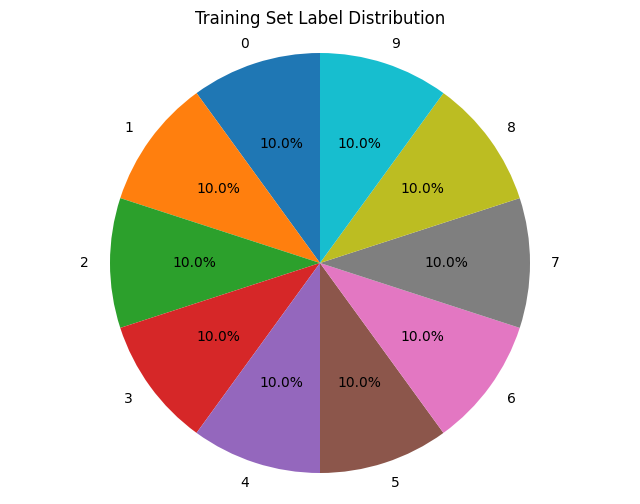

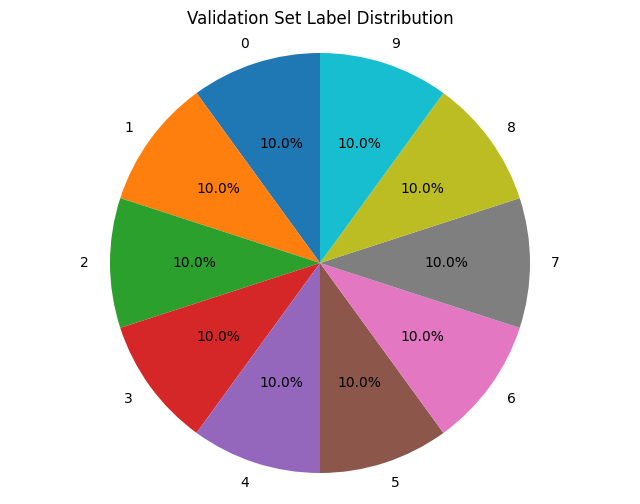

In [15]:
# Plotting pie chart for Training Set Label Distribution
unique_train, counts_train = np.unique(train_labels, return_counts=True)
plt.figure(figsize=(8, 6))
plt.pie(counts_train, labels=unique_train, autopct='%1.1f%%', startangle=90)
plt.title('Training Set Label Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

# Plotting pie chart for Validation Set (Test Set) Label Distribution
unique_test, counts_test = np.unique(test_labels, return_counts=True)
plt.figure(figsize=(8, 6))
plt.pie(counts_test, labels=unique_test, autopct='%1.1f%%', startangle=90)
plt.title('Validation Set Label Distribution')
plt.axis('equal')
plt.show()



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def residual_block(x, filters, kernel_size=(3,3), dropout_rate=0.4):
    """
    Residual block with stronger regularization and dropout to reduce overfitting.
    """
    shortcut = x
    if x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1,1), padding='same',
                                 kernel_regularizer=regularizers.l2(1e-4))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None,
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.Activation('relu')(x)
    x = layers.Dropout(dropout_rate)(x)  # Increased dropout
    return x

def create_cnn_model(input_shape=(128, 62, 1), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = layers.Conv2D(128, (3,3), padding='same', activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = residual_block(x, 256, dropout_rate=0.4)
    x = layers.MaxPooling2D((2,2))(x)
    
    x = residual_block(x, 256, dropout_rate=0.4)
    
    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)  # Increased dropout to 0.6
    
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

model = create_cnn_model(input_shape=(128, 62, 1), num_classes=10)
model.summary()

# Reduce learning rate further
lr = 0.0005
loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss=loss_fn,
    metrics=['accuracy']
)


from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model.h5", monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]


history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,  # Reduced for better generalization
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1
)


Test Accuracy: 0.9868


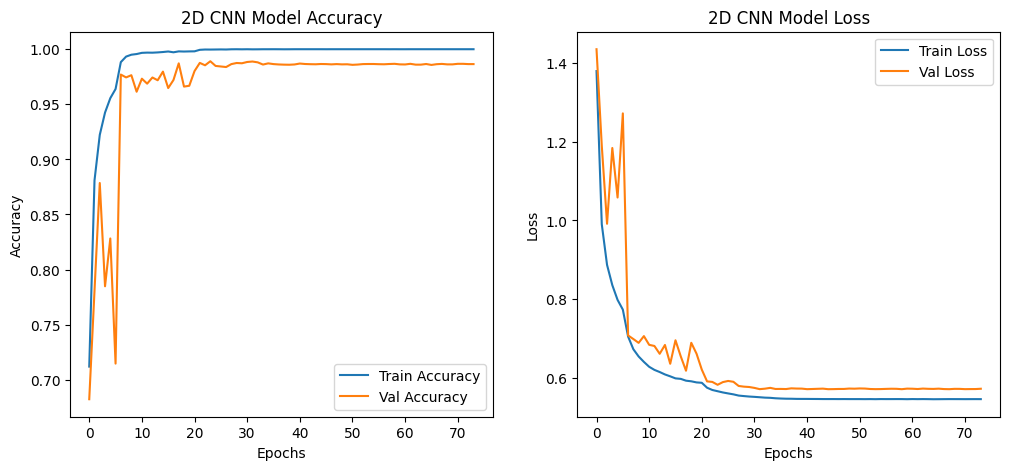

In [39]:

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('2D CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('2D CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Loaded model:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 62, 1)]         0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 128, 62, 64)          640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_31 (Ba  (None, 128, 62, 64)          256       ['conv2d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 31, 64)           0         ['batch_no

Processing audio files:   0%|          | 0/5 [00:00<?, ?it/s]

Processing Car_Honking_Youtube.mp3


Note: Illegal Audio-MPEG-Header 0x2c332c31 at offset 85440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


1/1 [==============================] - 0s 17ms/step


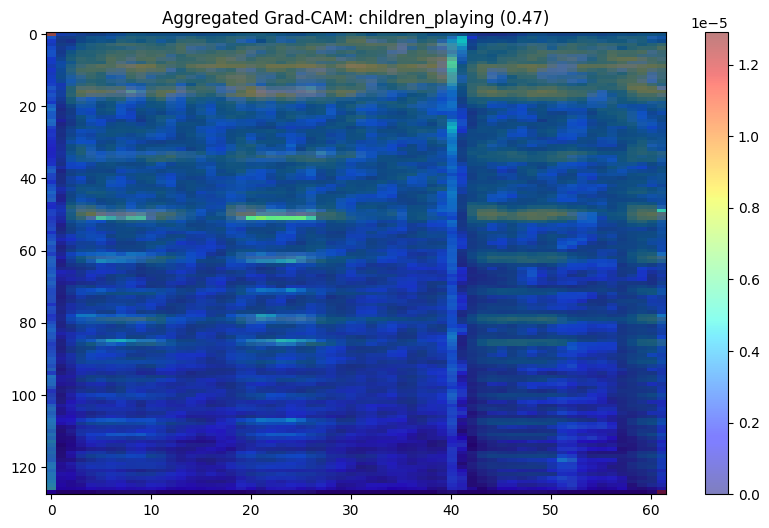

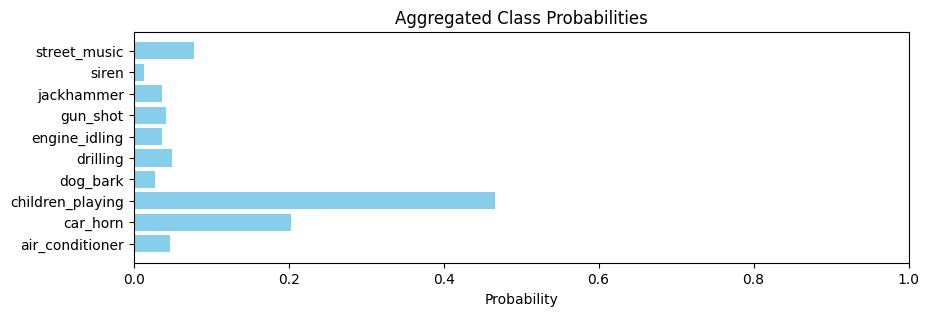

Processing audio files:  20%|██        | 1/5 [00:00<00:03,  1.13it/s]

Processing AC.wav
1/1 [==============================] - 0s 16ms/step


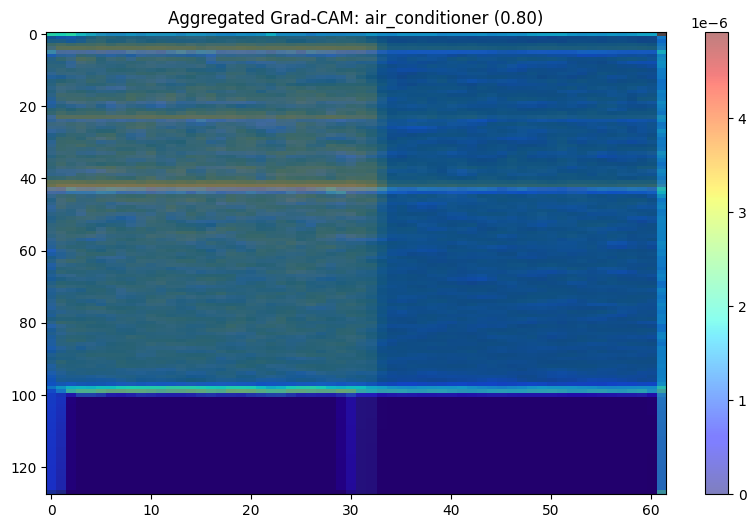

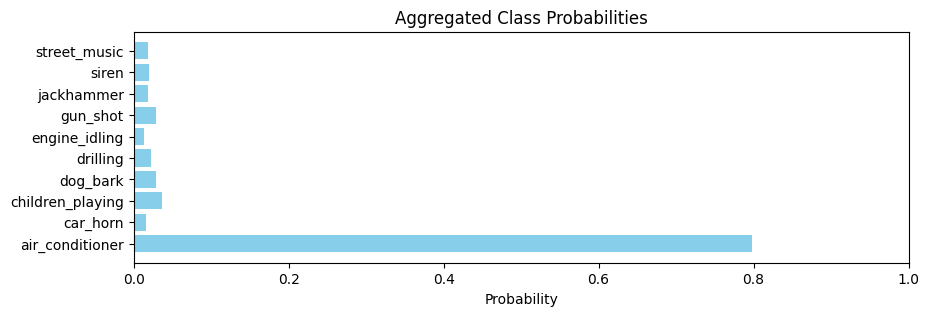

Processing audio files:  40%|████      | 2/5 [00:01<00:02,  1.33it/s]

Processing hornn.mp3
1/1 [==============================] - 0s 16ms/step


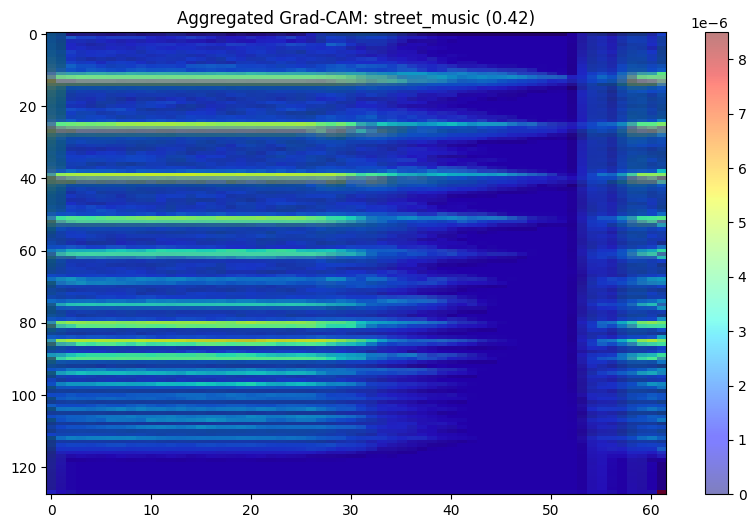

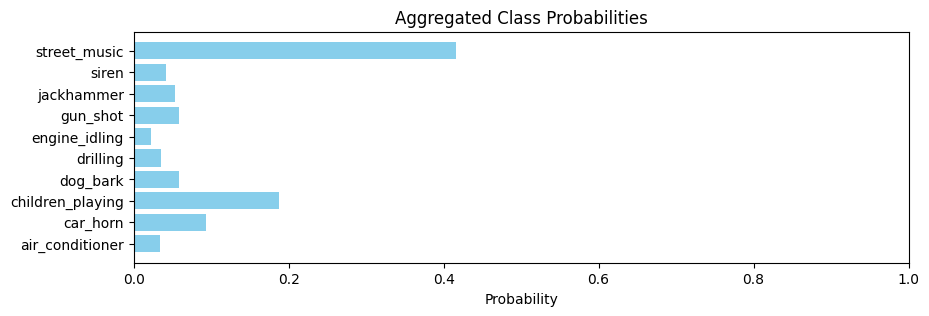

Processing audio files:  60%|██████    | 3/5 [00:02<00:01,  1.53it/s][src/libmpg123/parse.c:skip_junk():1260] error: Giving up searching valid MPEG header after 65536 bytes of junk.
/tmp/ipykernel_2873/1260710361.py:60: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_path, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Processing Jack.mp3
1/1 [==============================] - 0s 19ms/step


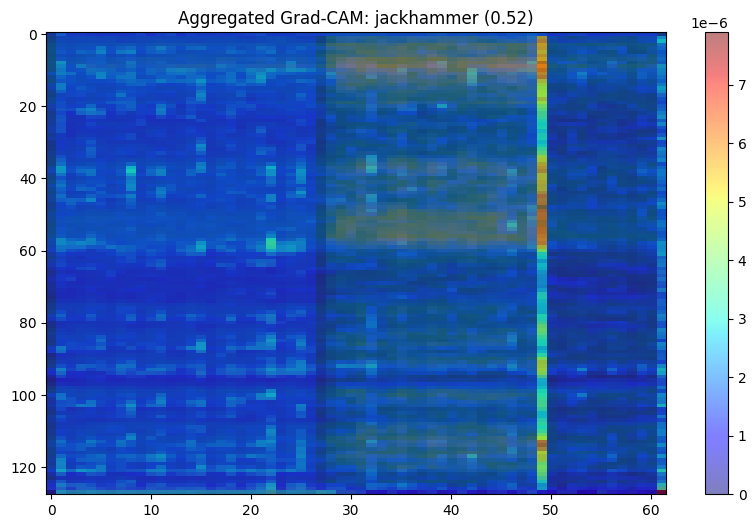

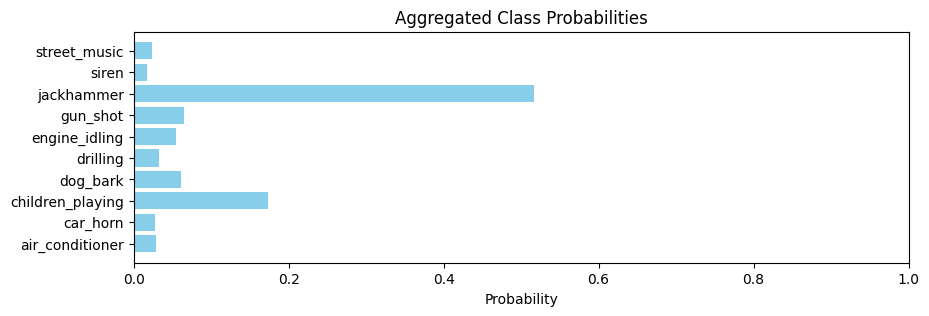

Processing audio files:  80%|████████  | 4/5 [00:03<00:00,  1.07it/s]

Processing Jack2.mp3
1/1 [==============================] - 0s 44ms/step


Note: Illegal Audio-MPEG-Header 0x2c332c37 at offset 178560.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


1/1 [==============================] - 0s 27ms/step


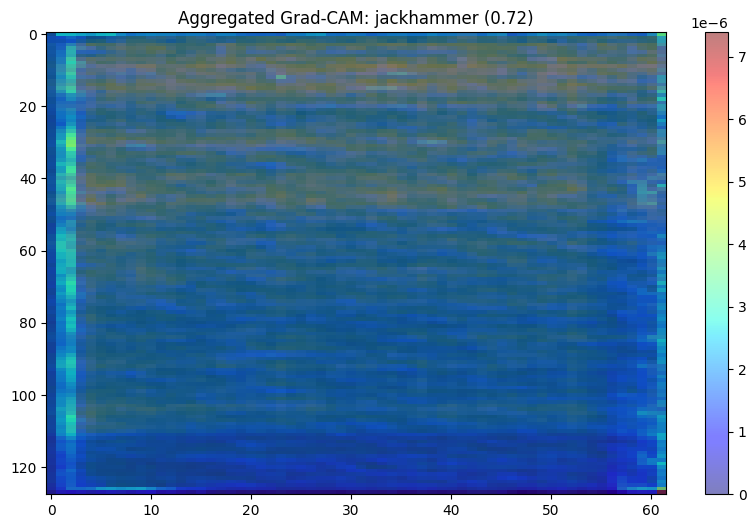

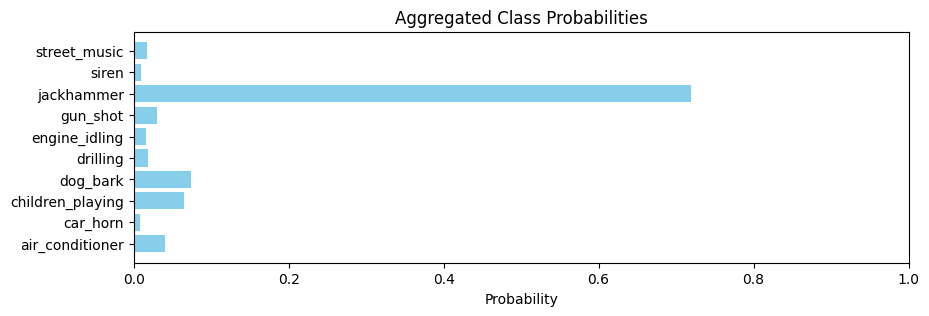

Processing audio files: 100%|██████████| 5/5 [00:04<00:00,  1.12it/s]


In [22]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import librosa
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# List of class names (ensure the order matches your training)
class_names = [
    "air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling",
    "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"
]


def fix_short_audio(audio, sr, min_duration=2.0):
    """Ensures the audio is at least min_duration seconds long by repeating it if needed."""
    desired_length = int(sr * min_duration)
    if len(audio) < desired_length:
        repeat_times = (desired_length // len(audio)) + 1
        audio = np.tile(audio, repeat_times)
        audio = audio[:desired_length]
    return audio

def trim_audio(audio, sr, trim_duration=0.25):
    """Trims trim_duration seconds from the start and end of the audio."""
    trim_samples = int(trim_duration * sr)
    if len(audio) > 2 * trim_samples:
        return audio[trim_samples:-trim_samples]
    else:
        return audio

def extract_features_from_audio(audio, sr, T=62, n_mels=128, n_fft=1024, hop_length=256):
    """
    Extracts a log-Mel spectrogram.
    If T is provided, the spectrogram is cropped/padded to T frames;
    Otherwise, the entire spectrogram is returned.
    Returns an array of shape (n_mels, T, 1).
    """
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels,
                                       n_fft=n_fft, hop_length=hop_length)
    log_S = librosa.power_to_db(S, ref=np.max)
    if T is not None:
        T_actual = log_S.shape[1]
        if T_actual < T:
            pad_width = T - T_actual
            log_S = np.pad(log_S, ((0,0),(0, pad_width)), mode="constant")
        else:
            log_S = log_S[:, :T]
    log_S = np.expand_dims(log_S, axis=-1)
    return log_S.astype(np.float32)

def preprocess_audio_chunks(audio_path, chunk_duration=1.0, T=62, n_mels=128, n_fft=1024, hop_length=256):
    """
    Loads an audio file, trims 0.25 sec from start and end, splits it into 1-second chunks,
    and extracts features from each chunk.
    """
    audio, sr = librosa.load(audio_path, sr=16000)
    audio = trim_audio(audio, sr, trim_duration=0.25)
    audio = fix_short_audio(audio, sr, min_duration=2.0)
    chunk_length = int(sr * chunk_duration)
    features = []
    for start in range(0, len(audio), chunk_length):
        chunk = audio[start:start+chunk_length]
        if len(chunk) < chunk_length:
            chunk = np.pad(chunk, (0, chunk_length - len(chunk)), mode="constant")
        feat = extract_features_from_audio(chunk, sr, T=T, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        features.append(feat)
    return features  # List of spectrograms

def apply_gradcam(model, spectrogram, layer_name="conv2d_22"):
    """
    Computes a Grad-CAM heatmap for the given model and spectrogram input.
    layer_name: name of the convolutional layer to use for Grad-CAM.
    Returns a heatmap resized to the spectrogram's spatial dimensions.
    """
    # Create a new model that outputs both the target layer and the final output.
    grad_model = keras.models.Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(spectrogram)
        loss = predictions[:, tf.argmax(predictions, axis=1)[0]]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap[0], 0)  # Apply ReLU
    heatmap = cv2.resize(heatmap, (spectrogram.shape[2], spectrogram.shape[1]))
    return heatmap

def predict_audio_chunks(audio_path, chunk_duration=1.0, T=62):
    """
    Splits the audio into chunks, makes predictions on each chunk, and aggregates predictions
    and Grad-CAM heatmaps.
    """
    chunk_spects = preprocess_audio_chunks(audio_path, chunk_duration=chunk_duration, T=T)
    predictions = []
    heatmaps = []
    for spect in chunk_spects:
        spect_exp = np.expand_dims(spect, axis=0)  # shape: (1, n_mels, T, 1)
        pred = model.predict(spect_exp)[0]
        predictions.append(pred)
        hm = apply_gradcam(model, spect_exp, layer_name="conv2d_22")
        heatmaps.append(hm)
    aggregated_pred = np.mean(np.stack(predictions, axis=0), axis=0)
    predicted_label_idx = np.argmax(aggregated_pred)
    confidence_score = aggregated_pred[predicted_label_idx]
    aggregated_heatmap = np.mean(np.stack(heatmaps, axis=0), axis=0)
    return aggregated_pred, class_names[predicted_label_idx], confidence_score, chunk_spects, aggregated_heatmap

def visualize_gradcam_chunks(audio_path, chunk_duration=1.0, T=62, layer_name="conv2d_22"):
    """
    Generates an aggregated Grad-CAM visualization for the audio file by processing it in 1-second chunks.
    Displays the average spectrogram with an overlay of the aggregated heatmap and a bar chart of class probabilities.
    """
    aggregated_pred, predicted_label, confidence_score, chunk_spects, aggregated_heatmap = predict_audio_chunks(audio_path, chunk_duration=chunk_duration, T=T)
    avg_spect = np.mean(np.stack(chunk_spects, axis=0), axis=0)  # shape: (n_mels, T, 1)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(avg_spect[:, :, 0], cmap="viridis", aspect="auto")
    plt.imshow(aggregated_heatmap, cmap="jet", alpha=0.5, aspect="auto")
    plt.title(f"Aggregated Grad-CAM: {predicted_label} ({confidence_score:.2f})")
    plt.colorbar()
    
    plt.figure(figsize=(10, 3))
    plt.barh(class_names, aggregated_pred, color="skyblue")
    plt.xlabel("Probability")
    plt.title("Aggregated Class Probabilities")
    plt.xlim(0, 1)
    plt.show()

audio_files = [
    "Car_Honking_Youtube.mp3", 
    "AC.wav", 
    "hornn.mp3", 
    "Jack.mp3", 
    "Jack2.mp3"
]

model = keras.models.load_model("best_model_old.h5")
print("Loaded model:")
model.summary()

for audio_file in tqdm(audio_files, desc="Processing audio files"):
    print(f"Processing {audio_file}")
    visualize_gradcam_chunks(audio_file, chunk_duration=1.0, T=62, layer_name="conv2d_22")


In [ ]:
import os
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score
from collections import defaultdict

# --- Set dataset paths ---
audio_dataset_path = "/notebooks/UrbanSound8K/audio"
dataset_path = "/notebooks/UrbanSound8K"
metadata_path = os.path.join(dataset_path, "metadata", "UrbanSound8K.csv")

# Load metadata (assuming CSV has 'fold', 'slice_file_name', 'classID' columns)
metadata = pd.read_csv(metadata_path)

# --- Load the trained model ---
model = tf.keras.models.load_model("best_model.h5")

# --- Preprocessing Functions (your functions) ---
# Ensure your functions fix_short_audio, extract_features_from_audio, etc. are defined in the scope.
# (The code you provided above should be already executed.)

def preprocess_audio(file_path):
    """
    Loads an audio file, fixes its length, extracts log-Mel spectrogram features,
    and returns a tensor of shape (1, n_mels, T, 1) for prediction.
    """
    audio, sr = librosa.load(file_path, sr=16000)
    audio = fix_short_audio(audio, sr, min_duration=2.0)
    # Here we use extract_features_from_audio to get a spectrogram of shape (128, T, 1)
    spectrogram = extract_features_from_audio(audio, sr, T=62, n_mels=128, n_fft=1024, hop_length=256)
    return np.expand_dims(spectrogram, axis=0)

# --- Predict on the Entire Dataset ---
true_labels = []
predictions = []
time_per_sample = []   # List of prediction times (per sample)
time_per_class = defaultdict(list)

# We'll iterate over all rows in the metadata.
# Note: Here, we assume that every row corresponds to one sample in your dataset.
for idx, row in metadata.iterrows():
    fold = row["fold"]
    file_name = row["slice_file_name"]
    true_label = row["classID"]  # true label as integer
    file_path = os.path.join(audio_dataset_path, f"fold{fold}", file_name)
    
    # Preprocess audio (non-augmented)
    feat = preprocess_audio(file_path)  # shape: (1, 128, 62, 1)
    
    start_time = time.perf_counter()
    pred = model.predict(feat)
    end_time = time.perf_counter()
    
    pred_label = np.argmax(pred)
    predictions.append(pred_label)
    true_labels.append(true_label)
    
    pred_time = end_time - start_time
    time_per_sample.append(pred_time)
    time_per_class[true_label].append(pred_time)

# --- Overall Accuracy ---
overall_accuracy = accuracy_score(true_labels, predictions)
print("Overall Accuracy on Entire Dataset: {:.4f}".format(overall_accuracy))

# --- Overall Counts ---
total_samples = len(true_labels)
correct_predictions = sum(1 for i in range(total_samples) if predictions[i] == true_labels[i])
wrong_predictions = total_samples - correct_predictions
print("Total Samples Predicted:", total_samples)
print("Total Correct Predictions:", correct_predictions)
print("Total Wrong Predictions:", wrong_predictions)

# --- Per-Class Statistics ---
class_data = []
unique_classes = sorted(set(true_labels))
for cls in unique_classes:
    indices = [i for i, label in enumerate(true_labels) if label == cls]
    total_cls = len(indices)
    correct_cls = sum(1 for i in indices if predictions[i] == true_labels[i])
    wrong_cls = total_cls - correct_cls
    acc_cls = (correct_cls / total_cls * 100) if total_cls > 0 else 0
    avg_time = np.mean(time_per_class[cls]) if time_per_class[cls] else 0
    class_data.append({
        "Class": cls,
        "Total Samples": total_cls,
        "Correct": correct_cls,
        "Wrong": wrong_cls,
        "Accuracy (%)": round(acc_cls, 2),
        "Avg Prediction Time (s)": round(avg_time, 4)
    })

df = pd.DataFrame(class_data)
print("\nPer-Class Statistics:")
print(df)

# --- Print Model Size Information ---
param_count = model.count_params()
print("\nTotal Model Parameters:", param_count)

model_file = "best_model.h5"
if os.path.exists(model_file):
    size_bytes = os.path.getsize(model_file)
    size_mb = size_bytes / (1024 * 1024)
    print("Model file size: {:.2f} MB".format(size_mb))


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D,
    Add, AvgPool2D, MaxPool2D, Concatenate, Reshape, Permute, 
    GlobalAveragePooling2D, Dense
)
from tensorflow.keras.models import Model

def static_channel_shuffle(x, groups=2):
    """Performs channel shuffle using static shapes.
    
    Args:
      x: Input tensor with shape (batch, H, W, C).
      groups: Number of groups to divide channels into.
      
    Returns:
      Tensor with shuffled channels, same shape as x.
    """
    # Get the static shape (assumes channels is known)
    shape = x.shape.as_list()  # [batch, H, W, C]
    H, W, C = shape[1], shape[2], shape[3]
    if C is None:
        raise ValueError("Channel dimension must be known statically.")
    if C % groups != 0:
        raise ValueError("Number of channels must be divisible by groups.")
    
    # Reshape to (H, W, C//groups, groups)
    x = Reshape((H, W, C // groups, groups))(x)
    # Permute the last two dimensions: (H, W, groups, C//groups)
    x = Permute((1, 2, 4, 3))(x)
    # Reshape back to (H, W, C)
    x = Reshape((H, W, C))(x)
    return x

def static_shuffle_unit(x, groups, channels, strides):
    """Stride-optimized unit with static shape handling for ShuffleNetV2."""
    y = x

    # Pointwise convolution: reduce channels by a factor (here, channels//4)
    x = Conv2D(channels // 4, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Apply channel shuffle
    x = static_channel_shuffle(x, groups)
    
    # Depthwise convolution
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    
    # Adjust channel count if stride==2
    if strides == 2:
        channels = channels // 2

    # Final pointwise convolution to adjust channels
    x = Conv2D(channels, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Residual connection (if stride is 1, add; if stride==2, concatenate after pooling y)
    if strides == 1:
        x = Add()([x, y])
    elif strides == 2:
        y = AvgPool2D(pool_size=3, strides=2, padding='same')(y)
        x = Concatenate()([x, y])
    
    return ReLU()(x)

def ShuffleNetV2(num_classes=10):
    """Constructs a ShuffleNetV2 model with static shape handling."""
    inp = Input((128, 62, 1))
    
    # Initial feature extraction: produces (32, 16, 24)
    x = Conv2D(24, kernel_size=3, strides=2, padding='same', use_bias=False)(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)  # Expected output: (32, 16, 24)

    # Stage 1 (expecting spatial: 16x8, channels: 48)
    x = static_shuffle_unit(x, groups=2, channels=48, strides=2)
    for _ in range(3):
        x = static_shuffle_unit(x, groups=2, channels=48, strides=1)

    # Stage 2 (expecting spatial: 8x4, channels: 96)
    x = static_shuffle_unit(x, groups=2, channels=96, strides=2)
    for _ in range(7):
        x = static_shuffle_unit(x, groups=2, channels=96, strides=1)

    # Stage 3 (expecting spatial: 4x2, channels: 192)
    x = static_shuffle_unit(x, groups=2, channels=192, strides=2)
    for _ in range(3):
        x = static_shuffle_unit(x, groups=2, channels=192, strides=1)

    # Final layers: global average pooling and classification
    x = GlobalAveragePooling2D()(x)
    out = Dense(num_classes, activation='softmax')(x)
    
    return Model(inp, out)

# Create and verify model
student_model = ShuffleNetV2()
student_model.summary()

2025-04-13 16:37:13.495443: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-13 16:37:13.662972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-13 16:37:13.663498: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 62, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 31, 24)           216       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 31, 24)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 64, 31, 24)           0         ['batch_normalization[0][0

In [17]:
from tensorflow.keras.models import load_model

# 2. Load the Teacher Model (Custom CNN)
#############################################
teacher_model = load_model("best_model_old.h5", compile=False)
teacher_model.trainable = False
print("Teacher model loaded:")
teacher_model.summary()

Teacher model loaded:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 62, 1)]         0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 128, 62, 64)          640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_31 (Ba  (None, 128, 62, 64)          256       ['conv2d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 31, 64)           0         ['

In [18]:
#############################################
# 3. Define Distiller for Knowledge Distillation (KD)
#############################################

import tensorflow as tf
from tensorflow import keras
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics,
                student_loss_fn, distillation_loss_fn,
                alpha=0.2, temperature=5):
        """
        alpha=0.3 => more emphasis on teacher's soft labels
        temperature=10 => more softened teacher distribution
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y_true = data
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_predictions = self.student(x, training=True)
            # Standard student loss
            student_loss = self.student_loss_fn(y_true, student_predictions)
            # Distillation loss
            soft_teacher = tf.nn.softmax(teacher_predictions / self.temperature, axis=1)
            soft_student = tf.nn.softmax(student_predictions / self.temperature, axis=1)
            distillation_loss = self.distillation_loss_fn(soft_teacher, soft_student)
            # Weighted combination
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        grads = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        self.compiled_metrics.update_state(y_true, student_predictions)
        return {m.name: m.result() for m in self.metrics} | {
            "student_loss": student_loss,
            "distillation_loss": distillation_loss,
            "loss": loss
        }

    def test_step(self, data):
        x, y_true = data
        teacher_predictions = self.teacher(x, training=False)
        student_predictions = self.student(x, training=False)

        student_loss = self.student_loss_fn(y_true, student_predictions)
        soft_teacher = tf.nn.softmax(teacher_predictions / self.temperature, axis=1)
        soft_student = tf.nn.softmax(student_predictions / self.temperature, axis=1)
        distillation_loss = self.distillation_loss_fn(soft_teacher, soft_student)
        loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        self.compiled_metrics.update_state(y_true, student_predictions)
        return {m.name: m.result() for m in self.metrics} | {
            "student_loss": student_loss,
            "distillation_loss": distillation_loss,
            "loss": loss
        }

# Instantiate the distiller model
distiller = Distiller(student=student_model, teacher=teacher_model)

# (If necessary, ensure X_train and X_test already have shape (num_samples, 128, 62, 1))
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (48000, 128, 62, 1)
Test data shape: (12000, 128, 62, 1)


In [19]:
import tensorflow as tf
from tensorflow import keras

distiller.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(),
    distillation_loss_fn=keras.losses.KLDivergence(),
    alpha=0.2,       # Heavier teacher guidance
    temperature=5   # More softened teacher distribution
)



early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=12, restore_best_weights=True, verbose=1
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1
)


batch_size = 32
epochs = 90

history_kd = distiller.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr]
)

student_model.save('student_model_distilled_static.keras')

Epoch 1/90


2025-04-08 05:33:32.938860: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-04-08 05:33:36.861604: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f353e6b52a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-08 05:33:36.861731: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2025-04-08 05:33:36.895232: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744090417.152926    7266 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 [==============================] - 100s 45ms/step - accuracy: 0.6459 - student_loss: 1.0247 - distillation_loss: 8.7022e-04 - loss: 0.2056 - val_accuracy: 0.7274 - val_student_loss: 0.9422 - val_distillation_loss: 6.7124e-04 - val_loss: 0.1890 - lr: 0.0010
Epoch 2/90
1500/1500 [==============================] - 60s 40ms/step - accuracy: 0.8082 - student_loss: 0.5672 - distillation_loss: 5.0484e-04 - loss: 0.1138 - val_accuracy: 0.7763 - val_student_loss: 0.7089 - val_distillation_loss: 6.7998e-04 - val_loss: 0.1423 - lr: 0.0010
Epoch 3/90
1500/1500 [==============================] - 59s 39ms/step - accuracy: 0.8579 - student_loss: 0.4228 - distillation_loss: 3.8314e-04 - loss: 0.0849 - val_accuracy: 0.7962 - val_student_loss: 0.5155 - val_distillation_loss: 5.1997e-04 - val_loss: 0.1035 - lr: 0.0010
Epoch 4/90
1500/1500 [==============================] - 59s 39ms/step - accuracy: 0.8853 - student_loss: 0.3381 - distillation_loss: 3.1355e-04 - loss: 0.0679 - val_accuracy: 0.84

Student model accuracy after KD: 0.9883


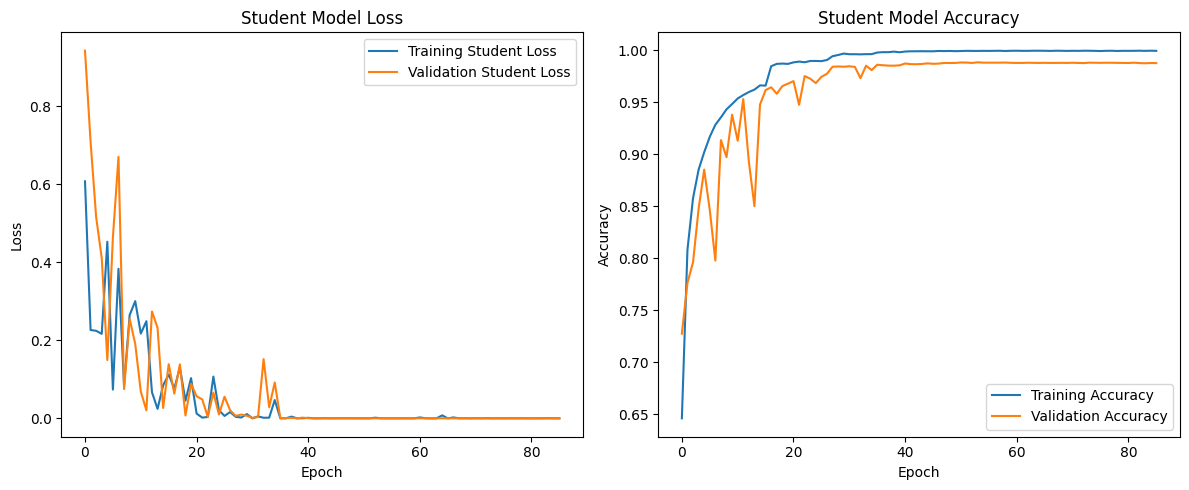

<Figure size 640x480 with 0 Axes>

In [20]:
student_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

loss, acc = student_model.evaluate(X_test, y_test, verbose=0)
print(f"Student model accuracy after KD: {acc:.4f}")

import matplotlib.pyplot as plt

# Extract history from the distiller training
history = history_kd.history

# Create subplots
plt.figure(figsize=(12, 5))

# 1. Loss curves
plt.subplot(1, 2, 1)
plt.plot(history['student_loss'], label='Training Student Loss')
plt.plot(history['val_student_loss'], label='Validation Student Loss')
plt.title('Student Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Accuracy curves
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Student Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Save the figures
plt.savefig('distillation_training_curves.png', dpi=300, bbox_inches='tight')


In [44]:
import os
import time
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

# --- Ensure test labels are one-hot encoded ---
num_classes = 10  # adjust if needed
if len(y_test.shape) == 1:
    y_test_oh = to_categorical(y_test, num_classes=num_classes)
else:
    y_test_oh = y_test

# --- Load the three models ---
teacher_model = keras.models.load_model("best_model.h5")
kd_model      = keras.models.load_model('student_model_distilled.keras')

# --- Compile models (if needed for evaluation) ---
teacher_model.compile(optimizer=keras.optimizers.Adam(), 
                      loss='categorical_crossentropy', metrics=['accuracy'])
kd_model.compile(optimizer=keras.optimizers.Adam(), 
                 loss='categorical_crossentropy', metrics=['accuracy'])

# --- Evaluate models on the test set ---
teacher_loss, teacher_acc = teacher_model.evaluate(X_test, y_test_oh, verbose=0)
kd_loss, kd_acc = kd_model.evaluate(X_test, y_test_oh, verbose=0)

# --- Get total parameter counts ---
teacher_params = teacher_model.count_params()
kd_params      = kd_model.count_params()

# --- Get file sizes (in MB) ---
teacher_size = os.path.getsize("best_model.h5") / (1024 * 1024)
kd_size      = os.path.getsize('student_model_distilled.keras') / (1024 * 1024)

# --- Helper function: Average inference time per sample ---
def avg_response_time(model, X, num_runs=5):
    times = []
    for _ in range(num_runs):
        start = time.time()
        _ = model.predict(X, verbose=0)
        times.append(time.time() - start)
    avg_time = np.mean(times) / X.shape[0]
    return avg_time

teacher_time = avg_response_time(teacher_model, X_test, num_runs=5)
kd_time      = avg_response_time(kd_model, X_test, num_runs=5)

# --- Build the results table using Pandas ---
data = {
    "Model Name": [
        "Teacher (Custom CNN)", 
        "Student (KD - ShuffleNet)", 
    ],
    "File Size (MB)": [
        round(teacher_size, 2), 
        round(kd_size, 2), 
    ],
    "Parameter Count": [
        teacher_params, 
        kd_params, 
    ],
    "Test Accuracy": [
        round(teacher_acc, 4), 
        round(kd_acc, 4), 
    ],
    "Avg Response Time (s/sample)": [
        round(teacher_time, 6), 
        round(kd_time, 6), 
    ]
}

df = pd.DataFrame(data)
print(df)


                  Model Name  File Size (MB)  Parameter Count  Test Accuracy  \
0       Teacher (Custom CNN)           25.86          2248202         0.9868   
1  Student (KD - ShuffleNet)            1.24           118930         0.9795   

   Avg Response Time (s/sample)  
0                      0.000248  
1                      0.000170  


Processing audio files:   0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


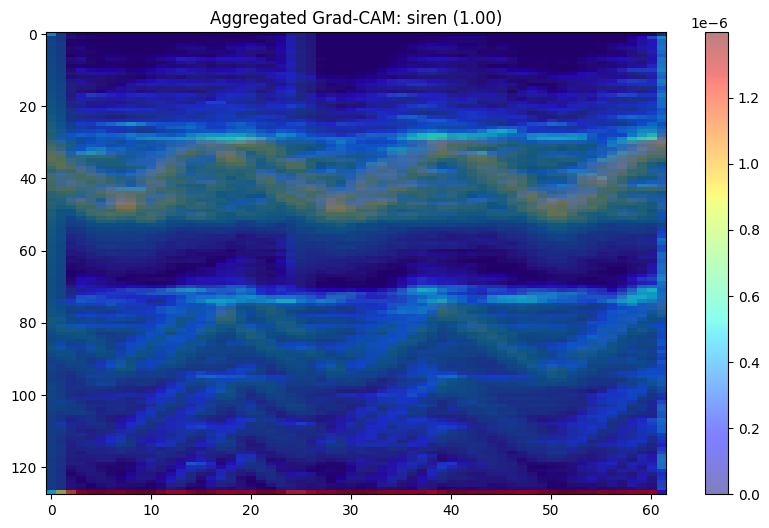

Processing audio files:  20%|██        | 1/5 [00:00<00:03,  1.16it/s]

Audio File: siren_final.wav
Predicted Class: siren
Class Probabilities (TFLite):
  air_conditioner: 0.0000
  car_horn: 0.0000
  children_playing: 0.0000
  dog_bark: 0.0000
  drilling: 0.0000
  engine_idling: 0.0000
  gun_shot: 0.0000
  jackhammer: 0.0000
  siren: 1.0000
  street_music: 0.0000
----------------------------------------
1/1 [==============================] - 0s 15ms/step


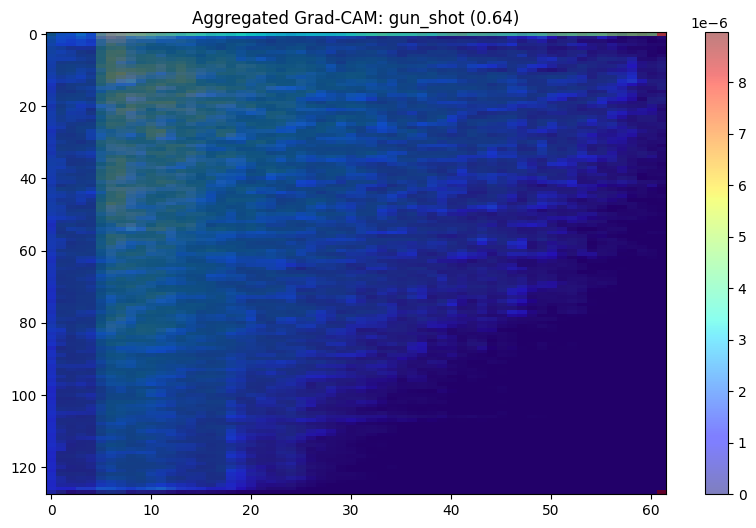

Processing audio files:  40%|████      | 2/5 [00:01<00:02,  1.28it/s]

Audio File: gun_shot.mp3
Predicted Class: gun_shot
Class Probabilities (TFLite):
  air_conditioner: 0.0000
  car_horn: 0.0000
  children_playing: 0.0001
  dog_bark: 0.3562
  drilling: 0.0000
  engine_idling: 0.0000
  gun_shot: 0.6438
  jackhammer: 0.0000
  siren: 0.0000
  street_music: 0.0000
----------------------------------------


Note: Illegal Audio-MPEG-Header 0x2c332c36 at offset 183360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x2c332c36 at offset 183360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.


1/1 [==============================] - 0s 16ms/step


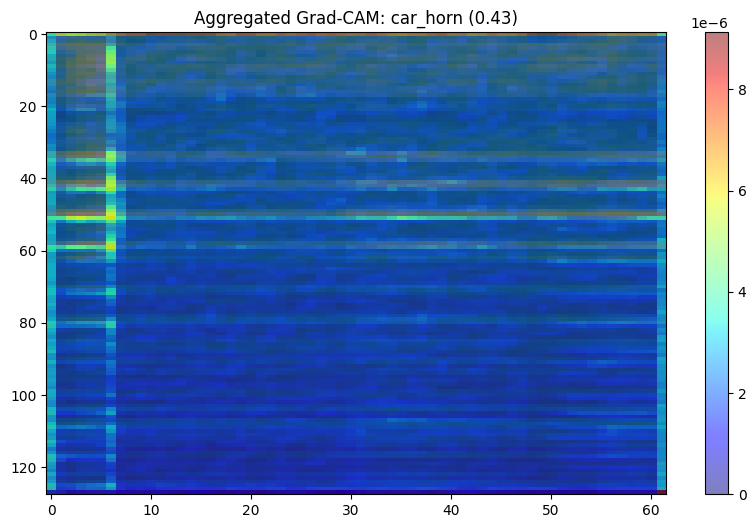

Processing audio files:  60%|██████    | 3/5 [00:02<00:01,  1.14it/s]

Audio File: Carr.mp3
Predicted Class: car_horn
Class Probabilities (TFLite):
  air_conditioner: 0.0004
  car_horn: 0.4285
  children_playing: 0.3220
  dog_bark: 0.0457
  drilling: 0.0003
  engine_idling: 0.0022
  gun_shot: 0.1999
  jackhammer: 0.0000
  siren: 0.0007
  street_music: 0.0002
----------------------------------------


1/1 [==============================] - 0s 16ms/step


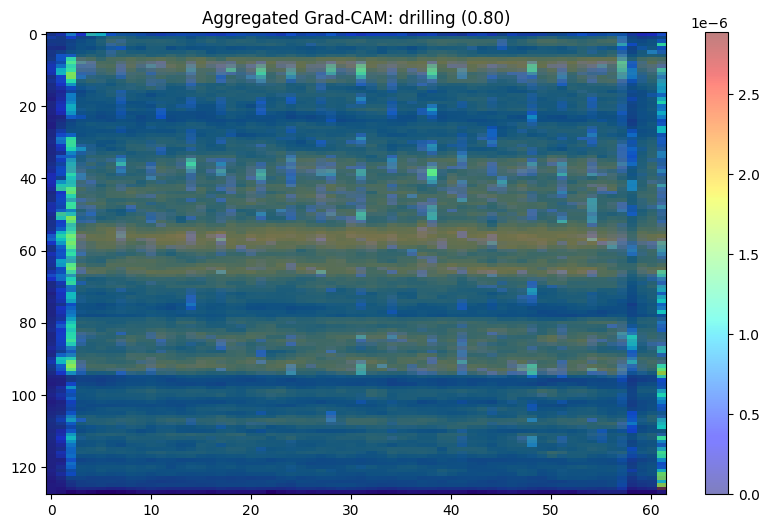

Audio File: jackhammer.wav
Predicted Class: drilling
Class Probabilities (TFLite):
  air_conditioner: 0.0000
  car_horn: 0.0001
  children_playing: 0.0000
  dog_bark: 0.0000
  drilling: 0.8001
  engine_idling: 0.0014
  gun_shot: 0.0000
  jackhammer: 0.1471
  siren: 0.0513
  street_music: 0.0000
----------------------------------------


Processing audio files:  80%|████████  | 4/5 [00:03<00:00,  1.22it/s]

1/1 [==============================] - 0s 15ms/step


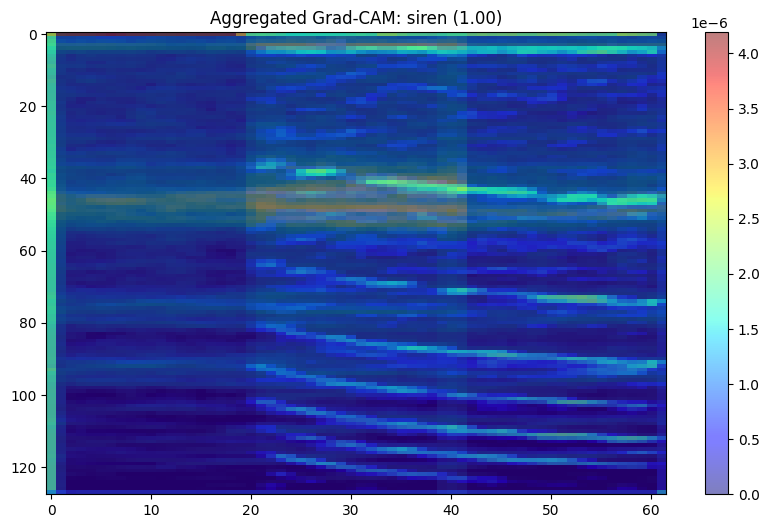

Processing audio files: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]

Audio File: police_siren_trimmed.wav
Predicted Class: siren
Class Probabilities (TFLite):
  air_conditioner: 0.0000
  car_horn: 0.0000
  children_playing: 0.0000
  dog_bark: 0.0000
  drilling: 0.0000
  engine_idling: 0.0000
  gun_shot: 0.0000
  jackhammer: 0.0000
  siren: 0.9999
  street_music: 0.0001
----------------------------------------


In [60]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import librosa
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

class_names = [
    "air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling",
    "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"
]

def fix_short_audio(audio, sr, min_duration=2.0):
    """Repeat the audio if it is shorter than min_duration seconds."""
    desired_length = int(sr * min_duration)
    if len(audio) < desired_length:
        repeat_times = (desired_length // len(audio)) + 1
        audio = np.tile(audio, repeat_times)
        audio = audio[:desired_length]
    return audio

def trim_audio(audio, sr, trim_duration=0.25):
    """Trim trim_duration seconds from start and end if possible."""
    trim_samples = int(trim_duration * sr)
    if len(audio) > 2 * trim_samples:
        return audio[trim_samples:-trim_samples]
    else:
        return audio

def extract_features_from_audio(audio, sr, T=62, n_mels=128, n_fft=1024, hop_length=256):
    """
    Extract a log‑Mel spectrogram from the audio and crop or pad it to T frames.
    Output shape: (n_mels, T, 1) → for our case, (128,62,1)
    """
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels,
                                       n_fft=n_fft, hop_length=hop_length)
    log_S = librosa.power_to_db(S, ref=np.max)
    T_actual = log_S.shape[1]
    if T_actual < T:
        pad_width = T - T_actual
        log_S = np.pad(log_S, ((0, 0), (0, pad_width)), mode="constant")
    else:
        log_S = log_S[:, :T]
    log_S = np.expand_dims(log_S, axis=-1)
    return log_S.astype(np.float32)

def split_audio(audio, sr, chunk_duration=1.0):
    """Split audio into chunks of duration chunk_duration (in seconds)."""
    chunk_length = int(sr * chunk_duration)
    chunks = []
    for start in range(0, len(audio), chunk_length):
        chunk = audio[start:start+chunk_length]
        if len(chunk) < chunk_length:
            chunk = np.pad(chunk, (0, chunk_length - len(chunk)), mode="constant")
        chunks.append(chunk)
    return chunks

def preprocess_audio_chunks(audio_path, chunk_duration=1.0, T=62, n_mels=128, n_fft=1024, hop_length=256):
    """
    Loads an audio file, trims 0.25 sec from start and end, ensures a minimum duration,
    splits it into 1‑second chunks, and extracts log‑Mel spectrogram features from each chunk.
    Returns a list of arrays of shape (128,62,1).
    """
    audio, sr = librosa.load(audio_path, sr=16000)
    audio = trim_audio(audio, sr, trim_duration=0.25)
    audio = fix_short_audio(audio, sr, min_duration=2.0)
    chunks = split_audio(audio, sr, chunk_duration=chunk_duration)
    features = [extract_features_from_audio(chunk, sr, T=T, n_mels=n_mels,
                                             n_fft=n_fft, hop_length=hop_length)
                for chunk in chunks]
    return features

def apply_gradcam_keras(model, spectrogram, layer_name="conv2d_22"):
    """
    Computes a Grad‑CAM heatmap for the given Keras model and spectrogram input.
    layer_name: name of the convolutional layer to use.
    Returns a heatmap resized to the spectrogram's (width, height).
    """
    grad_model = keras.models.Model(
        inputs=[model.input],
        outputs=[model.get_layer(layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(spectrogram)
        # Use the class with maximum prediction
        loss = predictions[:, tf.argmax(predictions, axis=1)[0]]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap[0], 0)  # ReLU
    heatmap = cv2.resize(heatmap, (spectrogram.shape[2], spectrogram.shape[1]))
    return heatmap

def predict_gradcam_chunks(keras_model, audio_path, chunk_duration=1.0, T=62, layer_name="conv2d_22"):
    """
    Uses the original Keras model to compute predictions and Grad‑CAM heatmaps on each chunk.
    Aggregates predictions and heatmaps over all chunks.
    """
    chunks = preprocess_audio_chunks(audio_path, chunk_duration=chunk_duration, T=T)
    predictions = []
    heatmaps = []
    for spect in chunks:
        spect_exp = np.expand_dims(spect, axis=0)  # Shape: (1, 128, 62, 1)
        pred = keras_model.predict(spect_exp)[0]
        predictions.append(pred)
        hm = apply_gradcam_keras(keras_model, spect_exp, layer_name=layer_name)
        heatmaps.append(hm)
    aggregated_pred = np.mean(np.stack(predictions, axis=0), axis=0)
    aggregated_heatmap = np.mean(np.stack(heatmaps, axis=0), axis=0)
    return aggregated_pred, chunks, aggregated_heatmap

#############################################
# TFLite Interpreter Prediction (Dynamic Quantization)
#############################################
def predict_tflite_chunks(interpreter, audio_path, chunk_duration=1.0, T=62):
    """
    Uses the dynamic quantized TFLite model to compute predictions on each chunk.
    Aggregates predictions (averages over chunks).
    """
    chunks = preprocess_audio_chunks(audio_path, chunk_duration=chunk_duration, T=T)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    predictions = []
    for spect in chunks:
        spect_exp = np.expand_dims(spect, axis=0).astype(np.float32)  # (1,128,62,1)
        # Dynamic quantized models expect float32 input.
        interpreter.set_tensor(input_details[0]['index'], spect_exp)
        interpreter.invoke()
        out = interpreter.get_tensor(output_details[0]['index'])
        predictions.append(out[0])
    aggregated_pred = np.mean(np.stack(predictions, axis=0), axis=0)
    return aggregated_pred, chunks

#############################################
# Visualization: Combine TFLite Predictions & Grad-CAM
#############################################
def visualize_prediction_and_gradcam(audio_path, chunk_duration=1.0, T=62, gradcam_layer="conv2d_22"):
    # Load original Keras model for Grad-CAM
    keras_model = keras.models.load_model("best_model.h5")
    # Load TFLite model (dynamic quantization)
    interpreter = tf.lite.Interpreter(model_path="student_model_distilled_dynamic.tflite")
    interpreter.allocate_tensors()
    
    # Get aggregated TFLite predictions
    aggregated_pred_tflite, chunks = predict_tflite_chunks(interpreter, audio_path, chunk_duration, T)
    predicted_idx = np.argmax(aggregated_pred_tflite)
    predicted_class = class_names[predicted_idx]
    confidence = aggregated_pred_tflite[predicted_idx]
    
    # Get aggregated Grad-CAM heatmap from Keras model
    aggregated_pred_keras, chunks, aggregated_heatmap = predict_gradcam_chunks(keras_model, audio_path, chunk_duration, T, gradcam_layer)
    
    # Average spectrogram for background visualization:
    avg_spect = np.mean(np.stack(chunks, axis=0), axis=0)  # shape: (128, T, 1)
    
    # Plot the averaged spectrogram with Grad-CAM overlay
    plt.figure(figsize=(10,6))
    plt.imshow(avg_spect[:, :, 0], cmap="viridis", aspect="auto")
    plt.imshow(aggregated_heatmap, cmap="jet", alpha=0.5, aspect="auto")
    plt.title(f"Aggregated Grad-CAM: {predicted_class} ({confidence:.2f})")
    plt.colorbar()
    plt.show()
    
    # Print prediction probabilities
    print(f"Audio File: {audio_path}")
    print("Predicted Class:", predicted_class)
    print("Class Probabilities (TFLite):")
    for i, prob in enumerate(aggregated_pred_tflite):
        print(f"  {class_names[i]}: {prob:.4f}")
    print("-" * 40)

#############################################
# Process a List of Audio Files
#############################################
audio_files = [
    "siren_final.wav",
    "gun_shot.mp3",
    "Carr.mp3",
    "jackhammer.wav",
    "police_siren_trimmed.wav"
]

for audio_file in tqdm(audio_files, desc="Processing audio files"):
    visualize_prediction_and_gradcam(audio_file, chunk_duration=1.0, T=62, gradcam_layer="conv2d_22")


In [26]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

model = keras.models.load_model("student_model_distilled_static.keras")
print("Loaded distilled student model:")


converter_dynamic = tf.lite.TFLiteConverter.from_keras_model(model)
converter_dynamic.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_dynamic = converter_dynamic.convert()
dynamic_file = "student_model_distilled_dynamic_static.tflite"
with open(dynamic_file, "wb") as f:
    f.write(tflite_model_dynamic)
print("Dynamic Range Quantized model saved as '{}'.".format(dynamic_file))


def representative_dataset():
    num_samples = 3000  # Adjust as needed
    for i in range(num_samples):
        # Take one sample at a time and cast to float32
        sample = X_train[i:i+1].astype(np.float32)
        yield [sample]

converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.representative_dataset = representative_dataset
# Force full integer quantization for compatible ops.
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set input and output types to int8.
converter_int8.inference_input_type = tf.int8
converter_int8.inference_output_type = tf.int8
tflite_model_int8 = converter_int8.convert()
int8_file = "student_model_distilled_int8_static.tflite"
with open(int8_file, "wb") as f:
    f.write(tflite_model_int8)
print("Full Integer Quantized model saved as '{}'.".format(int8_file))


converter_fp16 = tf.lite.TFLiteConverter.from_keras_model(model)
converter_fp16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_fp16.target_spec.supported_types = [tf.float16]
tflite_model_fp16 = converter_fp16.convert()
fp16_file = "student_model_distilled_fp16_static.tflite"
with open(fp16_file, "wb") as f:
    f.write(tflite_model_fp16)
print("Float16 Quantized model saved as '{}'.".format(fp16_file))


dyn_size = os.path.getsize(dynamic_file) / 1024.0  # KB
int8_size = os.path.getsize(int8_file) / 1024.0      # KB
fp16_size = os.path.getsize(fp16_file) / 1024.0        # KB
print(f"Dynamic Quantized Model Size: {dyn_size:.2f} KB")
print(f"Full INT8 Quantized Model Size: {int8_size:.2f} KB")
print(f"Float16 Quantized Model Size: {fp16_size:.2f} KB")


def evaluate_tflite_model(model_path, X, y):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    correct = 0
    total = X.shape[0]
    for i in range(total):
        # Prepare a single sample, ensuring shape is (1, 128, 62, 1)
        input_data = np.expand_dims(X[i], axis=0).astype(np.float32)
        # Quantize input if model expects int8
        if input_details[0]['dtype'] == np.int8:
            scale, zero_point = input_details[0]['quantization']
            input_data = (input_data / scale + zero_point).round().astype(np.int8)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        # Dequantize output if necessary
        if output_details[0]['dtype'] == np.int8:
            out_scale, out_zero_point = output_details[0]['quantization']
            output_data = out_scale * (output_data.astype(np.float32) - out_zero_point)
        # Assuming y is one-hot encoded; compare predicted label
        if np.argmax(output_data) == np.argmax(y[i]):
            correct += 1
    accuracy = correct / total * 100
    return accuracy

# Evaluate the three quantized models
dynamic_acc = evaluate_tflite_model(dynamic_file, X_test, y_test)
int8_acc = evaluate_tflite_model(int8_file, X_test, y_test)
fp16_acc = evaluate_tflite_model(fp16_file, X_test, y_test)

print(f"Dynamic Quantized Model Accuracy: {dynamic_acc:.2f}%")
print(f"Full INT8 Quantized Model Accuracy: {int8_acc:.2f}%")
print(f"Float16 Quantized Model Accuracy: {fp16_acc:.2f}%")


Loaded distilled student model:
INFO:tensorflow:Assets written to: /tmp/tmp3l323t_1/assets


INFO:tensorflow:Assets written to: /tmp/tmp3l323t_1/assets
2025-04-07 19:22:51.423403: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-04-07 19:22:51.424207: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-04-07 19:22:51.428598: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3l323t_1
2025-04-07 19:22:51.452463: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-04-07 19:22:51.452957: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3l323t_1
2025-04-07 19:22:51.540208: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-04-07 19:22:52.052874: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3l323t_1
2025-04-07 19:22:52.269753: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Dynamic Range Quantized model saved as 'student_model_distilled_dynamic_static.tflite'.
INFO:tensorflow:Assets written to: /tmp/tmp1kmvshq2/assets


INFO:tensorflow:Assets written to: /tmp/tmp1kmvshq2/assets
/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-07 19:23:13.033756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-04-07 19:23:13.034176: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-04-07 19:23:13.038087: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp1kmvshq2
2025-04-07 19:23:13.060911: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-04-07 19:23:13.060970: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp1kmvshq2
2025-04-07 19:23:13.144622: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-04-07 19:23:13.648662: I t

Full Integer Quantized model saved as 'student_model_distilled_int8_static.tflite'.
INFO:tensorflow:Assets written to: /tmp/tmp5u06qveq/assets


INFO:tensorflow:Assets written to: /tmp/tmp5u06qveq/assets
2025-04-07 19:23:50.064489: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-04-07 19:23:50.064556: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-04-07 19:23:50.069269: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5u06qveq
2025-04-07 19:23:50.098881: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-04-07 19:23:50.098954: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp5u06qveq
2025-04-07 19:23:50.198177: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-04-07 19:23:50.652497: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp5u06qveq
2025-04-07 19:23:50.824634: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Float16 Quantized model saved as 'student_model_distilled_fp16_static.tflite'.
Dynamic Quantized Model Size: 214.55 KB
Full INT8 Quantized Model Size: 233.16 KB
Float16 Quantized Model Size: 285.76 KB
Dynamic Quantized Model Accuracy: 97.70%
Full INT8 Quantized Model Accuracy: 97.61%
Float16 Quantized Model Accuracy: 97.69%


In [21]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

def get_tflite_converter(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.experimental_new_converter = False  # Disable experimental converter
    converter._experimental_disable_per_channel = True  # For ESP32 compatibility
    return converter


model = keras.models.load_model("student_model_distilled_static.keras")

# Dynamic Quantization
converter_dynamic = get_tflite_converter(model)
converter_dynamic.optimizations = [tf.lite.Optimize.DEFAULT]
converter_dynamic.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
tflite_dynamic = converter_dynamic.convert()
dynamic_file = "student_dynamic.tflite"
with open(dynamic_file, "wb") as f:
    f.write(tflite_dynamic)

# INT8 Quantization (ESP32-optimized)
def representative_dataset():
    for i in range(4000):  # Reduced samples for microcontroller compatibility
        yield [X_train[i:i+1].astype(np.float32)]

converter_int8 = get_tflite_converter(model)
converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.representative_dataset = representative_dataset
converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter_int8.inference_input_type = tf.int8
converter_int8.inference_output_type = tf.int8
tflite_int8 = converter_int8.convert()
int8_file = "student_int8.tflite"
with open(int8_file, "wb") as f:
    f.write(tflite_int8)

# Float16 Quantization
converter_fp16 = get_tflite_converter(model)
converter_fp16.optimizations = [tf.lite.Optimize.DEFAULT]
converter_fp16.target_spec.supported_types = [tf.float16]
tflite_fp16 = converter_fp16.convert()
fp16_file = "student_fp16.tflite"
with open(fp16_file, "wb") as f:
    f.write(tflite_fp16)

def evaluate_tflite_model(model_path, X, y):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    
    # Get quantization parameters safely
    input_quant = input_details.get('quantization', (1.0, 0))
    output_quant = output_details.get('quantization', (1.0, 0))
    
    correct = 0
    for i in range(len(X)):
        # Prepare input with explicit casting
        input_data = X[i].reshape(1, 128, 62, 1).astype(np.float32)
        
        # Quantize if needed with clamping
        if input_details['dtype'] == np.int8:
            scale, zero_point = input_quant
            input_data = np.clip(input_data/scale + zero_point, -128, 127).astype(np.int8)
        
        interpreter.set_tensor(input_details['index'], input_data)
        interpreter.invoke()
        
        # Process output
        output = interpreter.get_tensor(output_details['index'])
        if output_details['dtype'] == np.int8:
            scale, zero_point = output_quant
            output = (output.astype(np.float32) - zero_point) * scale
        
        if np.argmax(output) == np.argmax(y[i]):
            correct += 1
            
    return correct / len(X) * 100


print(f"Dynamic size: {os.path.getsize(dynamic_file)/1024:.1f} KB")
print(f"INT8 size: {os.path.getsize(int8_file)/1024:.1f} KB")
print(f"FP16 size: {os.path.getsize(fp16_file)/1024:.1f} KB")

print("\nEvaluating models...")
print(f"Dynamic Accuracy: {evaluate_tflite_model(dynamic_file, X_test, y_test):.1f}%")
print(f"INT8 Accuracy: {evaluate_tflite_model(int8_file, X_test, y_test):.1f}%")
print(f"FP16 Accuracy: {evaluate_tflite_model(fp16_file, X_test, y_test):.1f}%")

INFO:tensorflow:Assets written to: /tmp/tmpm6taznw6/assets


INFO:tensorflow:Assets written to: /tmp/tmpm6taznw6/assets
2025-04-08 07:00:20.321822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 07:00:20.322439: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-08 07:00:20.324525: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-08 07:00:20.326939: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 07:00:20.3

INFO:tensorflow:Assets written to: /tmp/tmpqo9dt76r/assets


INFO:tensorflow:Assets written to: /tmp/tmpqo9dt76r/assets
2025-04-08 07:00:46.301698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 07:00:46.301945: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-08 07:00:46.302126: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-08 07:00:46.302651: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 07:00:46.3

INFO:tensorflow:Assets written to: /tmp/tmptw0cscp2/assets


INFO:tensorflow:Assets written to: /tmp/tmptw0cscp2/assets
2025-04-08 07:01:30.297700: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 07:01:30.297938: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-08 07:01:30.298157: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-08 07:01:30.299208: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 07:01:30.2

Dynamic size: 174.6 KB
INT8 size: 154.2 KB
FP16 size: 263.8 KB

Evaluating models...


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Dynamic Accuracy: 98.9%
INT8 Accuracy: 98.7%
FP16 Accuracy: 98.8%


In [32]:
# convert_mel_to_header.py

def txt_to_header():
    """
    Convert mel_filter_bank.txt to mel_filter_bank.h
    Input file must have 128 lines with 513 coefficients each
    """
    input_path = "mel_filter_bank.txt"
    output_path = "mel_filter_bank.h"
    array_name = "mel_filter_bank"

    try:
        with open(input_path, 'r') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]
            
        if len(lines) != 128:
            raise ValueError(f"Expected 128 filters, got {len(lines)}")
            
        with open(output_path, 'w') as f:
            f.write(f"#ifndef {array_name.upper()}_H\n")
            f.write(f"#define {array_name.upper()}_H\n\n")
            f.write(f"const float {array_name}[128][513] = {{\n")
            
            for i, line in enumerate(lines):
                coefficients = line.split()
                if len(coefficients) != 513:
                    raise ValueError(f"Line {i+1}: Expected 513 coefficients, got {len(coefficients)}")
                    
                coeff_str = ", ".join([f"{float(c):.6f}f" for c in coefficients])
                f.write(f"    {{{coeff_str}}}{',' if i < 127 else ''}\n")
            
            f.write("};\n\n")
            f.write(f"#endif // {array_name.upper()}_H\n")
            
        print(f"Converted {input_path} → {output_path}")
        
    except Exception as e:
        print(f"Error: {str(e)}")
        print("Verify your mel_filter_bank.txt has:")
        print("- 128 lines (one per Mel filter)")
        print("- 513 space-separated values per line")
        print("- No headers or extra lines")
        exit(1)

if __name__ == "__main__":
    txt_to_header()

Converted mel_filter_bank.txt → mel_filter_bank.h


In [15]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import time

def get_tflite_converter(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.experimental_new_converter = False
    converter._experimental_disable_per_channel = True
    return converter

def quantize_model(model, name, X_train):
    quant_info = []

    # Dynamic Quantization
    converter_dynamic = get_tflite_converter(model)
    converter_dynamic.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_dynamic.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    tflite_dynamic = converter_dynamic.convert()
    dynamic_file = f"{name}_dynamic.tflite"
    with open(dynamic_file, "wb") as f:
        f.write(tflite_dynamic)

    # INT8 Quantization
    def representative_dataset():
        for i in range(4000):
            yield [X_train[i:i+1].astype(np.float32)]

    converter_int8 = get_tflite_converter(model)
    converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_int8.representative_dataset = representative_dataset
    converter_int8.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter_int8.inference_input_type = tf.int8
    converter_int8.inference_output_type = tf.int8
    tflite_int8 = converter_int8.convert()
    int8_file = f"{name}_int8.tflite"
    with open(int8_file, "wb") as f:
        f.write(tflite_int8)

    # Float16 Quantization
    converter_fp16 = get_tflite_converter(model)
    converter_fp16.optimizations = [tf.lite.Optimize.DEFAULT]
    converter_fp16.target_spec.supported_types = [tf.float16]
    tflite_fp16 = converter_fp16.convert()
    fp16_file = f"{name}_fp16.tflite"
    with open(fp16_file, "wb") as f:
        f.write(tflite_fp16)

    return {
        "name": name,
        "files": {
            "Dynamic": dynamic_file,
            "INT8": int8_file,
            "FP16": fp16_file
        }
    }

def evaluate_tflite_model(model_path, X, y):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    input_quant = input_details.get('quantization', (1.0, 0))
    output_quant = output_details.get('quantization', (1.0, 0))

    correct = 0
    total_time = 0

    for i in range(len(X)):
        input_data = X[i].reshape(1, 128, 62, 1).astype(np.float32)

        if input_details['dtype'] == np.int8:
            scale, zero_point = input_quant
            input_data = np.clip(input_data / scale + zero_point, -128, 127).astype(np.int8)

        interpreter.set_tensor(input_details['index'], input_data)
        start = time.time()
        interpreter.invoke()
        total_time += time.time() - start

        output = interpreter.get_tensor(output_details['index'])
        if output_details['dtype'] == np.int8:
            scale, zero_point = output_quant
            output = (output.astype(np.float32) - zero_point) * scale

        if np.argmax(output) == np.argmax(y[i]):
            correct += 1

    acc = correct / len(X) * 100
    avg_time = total_time / len(X) * 1000  # ms
    return acc, avg_time


models_info = []


model_paths = [
    ("student_model_distilled_static.keras", "student"),
    ("mobilenet_trained_model.h5", "mobilenet"),
    ("squeezenet_trained_model.h5", "squeezenet")
]

for model_path, name in model_paths:
    model = keras.models.load_model(model_path)
    info = quantize_model(model, name, X_train)
    models_info.append(info)

print("\n" + "="*60)
for model_info in models_info:
    print(f"Model: {model_info['name'].capitalize()}")
    print(f"{'Quant Type':<10} | {'Size (KB)':<10} | {'Accuracy (%)':<15} | {'Avg Time (ms)':<15}")
    print("-"*60)
    for quant_type, file_path in model_info["files"].items():
        size_kb = os.path.getsize(file_path) / 1024
        acc, avg_time = evaluate_tflite_model(file_path, X_test, y_test)
        print(f"{quant_type:<10} | {size_kb:<10.1f} | {acc:<15.2f} | {avg_time:<15.2f}")
    print("="*60)


print("\nINT8 Quantization Summary")
print(f"{'Model':<15} | {'Size (KB)':<10} | {'Accuracy (%)':<15} | {'Avg Time (ms)':<15}")
print("-"*60)
for model_info in models_info:
    name = model_info["name"]
    file_path = model_info["files"]["INT8"]
    size_kb = os.path.getsize(file_path) / 1024
    acc, avg_time = evaluate_tflite_model(file_path, X_test, y_test)
    print(f"{name:<15} | {size_kb:<10.1f} | {acc:<15.2f} | {avg_time:<15.2f}")


2025-04-08 08:02:08.220280: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:02:08.441045: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:02:08.441366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

INFO:tensorflow:Assets written to: /tmp/tmpobo_d4t0/assets


INFO:tensorflow:Assets written to: /tmp/tmpobo_d4t0/assets
2025-04-08 08:02:28.019905: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:02:28.021141: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-08 08:02:28.021535: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-08 08:02:28.022439: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:02:28.0

INFO:tensorflow:Assets written to: /tmp/tmpw0l1bhsb/assets


INFO:tensorflow:Assets written to: /tmp/tmpw0l1bhsb/assets
2025-04-08 08:02:50.174995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:02:50.175243: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-08 08:02:50.175379: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-08 08:02:50.175898: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:02:50.1

INFO:tensorflow:Assets written to: /tmp/tmpz6_quv4b/assets


INFO:tensorflow:Assets written to: /tmp/tmpz6_quv4b/assets
2025-04-08 08:03:36.603139: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:03:36.603396: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-08 08:03:36.604262: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-08 08:03:36.604900: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:03:36.6

INFO:tensorflow:Assets written to: /tmp/tmplb7kr846/assets


INFO:tensorflow:Assets written to: /tmp/tmplb7kr846/assets
2025-04-08 08:03:52.038132: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:03:52.038409: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-08 08:03:52.038621: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-08 08:03:52.039129: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:03:52.0

INFO:tensorflow:Assets written to: /tmp/tmp0qdfr9o_/assets


INFO:tensorflow:Assets written to: /tmp/tmp0qdfr9o_/assets
2025-04-08 08:04:03.757913: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:04:03.758168: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-08 08:04:03.758339: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-08 08:04:03.758916: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:04:03.7

INFO:tensorflow:Assets written to: /tmp/tmpwbe535zn/assets


INFO:tensorflow:Assets written to: /tmp/tmpwbe535zn/assets
2025-04-08 08:05:08.697755: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:05:08.698125: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-08 08:05:08.700622: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-08 08:05:08.702581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:05:08.7

INFO:tensorflow:Assets written to: /tmp/tmpaixa8i2d/assets


INFO:tensorflow:Assets written to: /tmp/tmpaixa8i2d/assets
2025-04-08 08:05:21.079230: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:05:21.079500: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-08 08:05:21.079671: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-08 08:05:21.080149: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:05:21.0

INFO:tensorflow:Assets written to: /tmp/tmp495t_5yj/assets


INFO:tensorflow:Assets written to: /tmp/tmp495t_5yj/assets
2025-04-08 08:05:30.211049: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:05:30.211304: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-08 08:05:30.211441: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-08 08:05:30.214331: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:05:30.2

INFO:tensorflow:Assets written to: /tmp/tmpb0_ui_t4/assets


INFO:tensorflow:Assets written to: /tmp/tmpb0_ui_t4/assets
2025-04-08 08:07:22.303830: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:07:22.304224: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-04-08 08:07:22.306833: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-08 08:07:22.308282: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 08:07:22.3


Model: Student
Quant Type | Size (KB)  | Accuracy (%)    | Avg Time (ms)  
------------------------------------------------------------


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Dynamic    | 174.6      | 98.85           | 0.65           
INT8       | 154.2      | 98.74           | 0.70           
FP16       | 263.8      | 98.82           | 0.29           
Model: Mobilenet
Quant Type | Size (KB)  | Accuracy (%)    | Avg Time (ms)  
------------------------------------------------------------
Dynamic    | 238.8      | 98.19           | 3.50           
INT8       | 234.5      | 98.13           | 1.79           
FP16       | 435.4      | 98.26           | 0.95           
Model: Squeezenet
Quant Type | Size (KB)  | Accuracy (%)    | Avg Time (ms)  
------------------------------------------------------------
Dynamic    | 1245.5     | 96.41           | 10.08          
INT8       | 1248.2     | 96.11           | 7.35           
FP16       | 2459.3     | 96.51           | 4.63           

INT8 Quantization Summary
Model           | Size (KB)  | Accuracy (%)    | Avg Time (ms)  
------------------------------------------------------------
student         | 154.2      |

In [17]:
import tensorflow as tf
import numpy as np
import os
import time
from tensorflow import keras
from sklearn.metrics import classification_report

# Load models
shufflenet_model = keras.models.load_model("shufflenet_trained_model.keras")
teacher_model = keras.models.load_model("best_model_old.h5")
student_model = keras.models.load_model("student_model_distilled_static.keras")

# Ordered model list
models = {
    "ShuffleNet": ("shufflenet_trained_model.keras", shufflenet_model),
    "Custom CNN (Teacher)": ("best_model_old.h5", teacher_model),
    "KD ShuffleNet (Student)": ("student_model_distilled_static.keras", student_model),
}


def evaluate_model(model, X, y, batch_size=32):
    start = time.time()
    predictions = model.predict(X, batch_size=batch_size, verbose=0)
    total_time = time.time() - start
    accuracy = np.mean(np.argmax(predictions, axis=1) == np.argmax(y, axis=1)) * 100
    avg_time_ms = (total_time / len(X)) * 1000
    return predictions, accuracy, avg_time_ms

# Evaluate and collect results
results = []
for name, (path, model) in models.items():
    size_kb = os.path.getsize(path) / 1024
    predictions, accuracy, avg_time = evaluate_model(model, X_test, y_test)
    results.append((name, f"{accuracy:.2f}", f"{avg_time:.2f}", f"{size_kb:.1f}"))
    
    # Print classification report for student
    if name == "KD ShuffleNet (Student)":
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(predictions, axis=1)
        print(f"\n Classification Report for {name}:\n")
        print(classification_report(y_true, y_pred, digits=4))

# Print final comparison table
print("\n Model Comparison Table")
print(f"{'Model Name':<28} {'Accuracy (%)':<15} {'Avg Time (ms)':<18} {'Size (KB)':<10}")
print("-" * 75)
for row in results:
    print(f"{row[0]:<28} {row[1]:<15} {row[2]:<18} {row[3]:<10}")



 Classification Report for KD ShuffleNet (Student):

              precision    recall  f1-score   support

           0     0.9942    0.9958    0.9950      1200
           1     0.9967    0.9975    0.9971      1200
           2     0.9661    0.9725    0.9693      1200
           3     0.9833    0.9825    0.9829      1200
           4     0.9801    0.9850    0.9825      1200
           5     0.9992    0.9967    0.9979      1200
           6     0.9992    0.9983    0.9987      1200
           7     0.9891    0.9850    0.9871      1200
           8     0.9908    0.9867    0.9887      1200
           9     0.9841    0.9825    0.9833      1200

    accuracy                         0.9882     12000
   macro avg     0.9883    0.9883    0.9883     12000
weighted avg     0.9883    0.9882    0.9883     12000


 Model Comparison Table
Model Name                   Accuracy (%)    Avg Time (ms)      Size (KB) 
---------------------------------------------------------------------------
ShuffleNet 

In [19]:
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)
from tensorflow import keras
import numpy as np

# Load student model
student_model = keras.models.load_model("student_model_distilled_static.keras")

# Predict all at once (batch prediction)
y_true = np.argmax(y_test, axis=1)
predictions = student_model.predict(X_test, batch_size=32, verbose=0)
y_pred = np.argmax(predictions, axis=1)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
macro_precision = precision_score(y_true, y_pred, average='macro')
weighted_precision = precision_score(y_true, y_pred, average='weighted')
macro_recall = recall_score(y_true, y_pred, average='macro')
weighted_recall = recall_score(y_true, y_pred, average='weighted')

# Print classification report
print("\n Classification Report for KD ShuffleNet (Student):")
print(classification_report(y_true, y_pred, digits=4))

# Print metrics table
print("\n Evaluation Metrics Table:")
print(f"{'Metric':<25} {'Value':>10}")
print("-" * 40)
print(f"{'Accuracy':<25} {accuracy:.4f}")
print(f"{'Macro F1 Score':<25} {macro_f1:.4f}")
print(f"{'Weighted F1 Score':<25} {weighted_f1:.4f}")
print(f"{'Macro Precision':<25} {macro_precision:.4f}")
print(f"{'Weighted Precision':<25} {weighted_precision:.4f}")
print(f"{'Macro Recall':<25} {macro_recall:.4f}")
print(f"{'Weighted Recall':<25} {weighted_recall:.4f}")



 Classification Report for KD ShuffleNet (Student):
              precision    recall  f1-score   support

           0     0.9942    0.9958    0.9950      1200
           1     0.9967    0.9975    0.9971      1200
           2     0.9661    0.9725    0.9693      1200
           3     0.9833    0.9825    0.9829      1200
           4     0.9801    0.9850    0.9825      1200
           5     0.9992    0.9967    0.9979      1200
           6     0.9992    0.9983    0.9987      1200
           7     0.9891    0.9850    0.9871      1200
           8     0.9908    0.9867    0.9887      1200
           9     0.9841    0.9825    0.9833      1200

    accuracy                         0.9882     12000
   macro avg     0.9883    0.9883    0.9883     12000
weighted avg     0.9883    0.9882    0.9883     12000


 Evaluation Metrics Table:
Metric                         Value
----------------------------------------
Accuracy                  0.9882
Macro F1 Score            0.9883
Weighted F1 Scor

In [23]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="shufflenet_int8.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get quantization params
input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']

# Get input shape
input_shape = input_details[0]['shape']  # Should be (1, 128, 62, 1)

# Ground truth labels
y_true = np.argmax(y_test, axis=1)
y_pred = []

# Loop over test data
for i in range(len(X_test)):
    x = X_test[i].reshape(input_shape).astype(np.float32)

    # Quantize input to int8
    if input_scale > 0:
        x_q = (x / input_scale + input_zero_point).astype(np.int8)
    else:
        x_q = x.astype(np.int8)

    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], x_q)
    interpreter.invoke()

    # Get output tensor
    output = interpreter.get_tensor(output_details[0]['index'])[0]

    # Dequantize output if needed
    if output_scale > 0:
        output = (output.astype(np.float32) - output_zero_point) * output_scale

    y_pred.append(np.argmax(output))

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
macro_f1 = f1_score(y_true, y_pred, average='macro')
weighted_f1 = f1_score(y_true, y_pred, average='weighted')
macro_precision = precision_score(y_true, y_pred, average='macro')
weighted_precision = precision_score(y_true, y_pred, average='weighted')
macro_recall = recall_score(y_true, y_pred, average='macro')
weighted_recall = recall_score(y_true, y_pred, average='weighted')

# Print classification report
print("\n Classification Report for Quantized KD ShuffleNet (INT8):")
print(classification_report(y_true, y_pred, digits=4))

# Print metrics table
print("\n Evaluation Metrics Table:")
print(f"{'Metric':<25} {'Value':>10}")
print("-" * 40)
print(f"{'Accuracy':<25} {accuracy:.4f}")
print(f"{'Macro F1 Score':<25} {macro_f1:.4f}")
print(f"{'Weighted F1 Score':<25} {weighted_f1:.4f}")
print(f"{'Macro Precision':<25} {macro_precision:.4f}")
print(f"{'Weighted Precision':<25} {weighted_precision:.4f}")
print(f"{'Macro Recall':<25} {macro_recall:.4f}")
print(f"{'Weighted Recall':<25} {weighted_recall:.4f}")



 Classification Report for Quantized KD ShuffleNet (INT8):
              precision    recall  f1-score   support

           0     0.9745    0.9867    0.9805      1200
           1     0.9875    0.9883    0.9879      1200
           2     0.9239    0.9517    0.9376      1200
           3     0.9819    0.9492    0.9653      1200
           4     0.9716    0.9692    0.9704      1200
           5     0.9915    0.9758    0.9836      1200
           6     1.0000    0.9883    0.9941      1200
           7     0.9668    0.9717    0.9692      1200
           8     0.9764    0.9642    0.9702      1200
           9     0.9473    0.9733    0.9601      1200

    accuracy                         0.9718     12000
   macro avg     0.9721    0.9718    0.9719     12000
weighted avg     0.9721    0.9718    0.9719     12000


 Evaluation Metrics Table:
Metric                         Value
----------------------------------------
Accuracy                  0.9718
Macro F1 Score            0.9719
Weighted 

In [13]:
import tensorflow as tf

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path="student_int8.tflite")
interpreter.allocate_tensors()

# Get the list of tensor details
tensor_details = interpreter.get_tensor_details()

# Extract layer names (op names)
ops = set()
for detail in tensor_details:
    if 'name' in detail:
        layer_name = detail['name']
        # Remove tensor suffix if needed (like ':0')
        base_name = layer_name.split(':')[0]
        ops.add(base_name)

# Print distinct layer names
print("Distinct Layer Names:")
for op in sorted(ops):
    print(op)


Distinct Layer Names:

Identity
input_1
model/average_pooling2d/AvgPool
model/average_pooling2d_1/AvgPool
model/average_pooling2d_2/AvgPool
model/batch_normalization_11/FusedBatchNormV3
model/batch_normalization_12/FusedBatchNormV3
model/batch_normalization_14/FusedBatchNormV3
model/batch_normalization_15/FusedBatchNormV3
model/batch_normalization_17/FusedBatchNormV3
model/batch_normalization_18/FusedBatchNormV3
model/batch_normalization_2/FusedBatchNormV3
model/batch_normalization_20/FusedBatchNormV3
model/batch_normalization_21/FusedBatchNormV3
model/batch_normalization_23/FusedBatchNormV3
model/batch_normalization_24/FusedBatchNormV3
model/batch_normalization_26/FusedBatchNormV3
model/batch_normalization_27/FusedBatchNormV3
model/batch_normalization_29/FusedBatchNormV3
model/batch_normalization_3/FusedBatchNormV3
model/batch_normalization_30/FusedBatchNormV3
model/batch_normalization_32/FusedBatchNormV3
model/batch_normalization_33/FusedBatchNormV3
model/batch_normalization_35/Fused

In [15]:
import tensorflow as tf

# Path to your TFLite model
model_path = "student_int8.tflite"

# Print full model structure and ops used
tf.lite.experimental.Analyzer.analyze(model_path=model_path)


=== student_int8.tflite ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the DEPTHWISE_CONV_2D op takes
tensor #0 and tensor #114 and tensor #113 as input and produces tensor #115 as output.

Subgraph#0 main(T#0) -> [T#237]
  Op#0 DEPTHWISE_CONV_2D(T#0, T#114, T#113[-9367, 11344, 13532, 15428, -9241, ...]) -> [T#115]
  Op#1 MAX_POOL_2D(T#115) -> [T#116]
  Op#2 CONV_2D(T#116, T#112, T#111[-1755, -1923, 657, -87, -1590, ...]) -> [T#117]
  Op#3 AVERAGE_POOL_2D(T#116) -> [T#118]
  Op#4 RESHAPE(T#117, T#1[1, 32, 16, 6, 2]) -> [T#119]
  Op#5 TRANSPOSE(T#119, T#2[0, 1, 2, 4, 3]) -> [T#120]
  Op#6 RESHAPE(T#120, T#3[1, 32, 16, 12]) -> [T#121]
  Op#7 DEPTHWISE_CONV_2D(T#121, T#110, T#109[-514, -526, -581, -724, -2446, ...]) -> [T#122]
  Op#8 CONV_2D(T#122, T#108, T#107[984, 915, 135, -117, -52, ...]) -> [T#123]
  Op#9 CONCATENATION(T#123, T#118) -> [T#124]
  Op#10 RELU(T#124) -> [T#125]
  Op#11 CONV_2D(T